In [2]:
# noinspection JupyterPackage
import os
import pandas as pd
import numpy as np

In [3]:
data_dir = '/Users/xiaoqianxiao/UKB/data'
participantsInfo_file = 'participants_structural.csv'
participantsInfo_file_path = os.path.join(data_dir,participantsInfo_file)
participantsInfo_df = pd.read_csv(participantsInfo_file_path)

/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_39514/3336274664.py:4: DtypeWarning: Columns (266,268,270,272,274,276) have mixed types. Specify dtype option on import or set low_memory=False.
  participantsInfo_df = pd.read_csv(participantsInfo_file_path)


In [12]:
# Tian 1:10, 17:26
#'HIP-rh','AMY-rh','pTHA-rh','aTHA-rh','NAc-rh','GP-rh','PUT-rh','CAU-rh',
#'HIP-lh','AMY-lh','pTHA-lh','aTHA-lh','NAc-lh','GP-lh','PUT-lh','CAU-lh'
subcortical_index = [i + 360 for i in range(0, 5)] + [i + 360 for i in range(8, 13)]
subcortical_index_ori = list(range(0,5)) + list(range(8,13))


# Schaefer: 
# lh-mPFC: 199:205
# rh-mPFC: 464:470
# lh-Ins: 67, 108:111, 126:128
# rh-Ins: 319, 361:364, 383:386
## ACC: 390
# Glasser
cortical_roi = ['lh_dlPFC', 'rh_dlPFC', 'lh_mPFC', 'rh_mPFC', 'lh_PCC', 'rh_PCC', 'lh_Ins', 'rh_Ins']
lh_dlPFC_index = [205, 246, 247, 249, 250, 252, 262, 263, 264, 265, 266, 276, 277]
rh_dlPFC_index = [25, 66, 67, 69, 70, 72, 82, 83, 84, 85, 86, 96, 97]
lh_mPFC_index = [236, 237, 238, 239, 240, 241, 242, 243, 244, 248, 267, 343, 344, 345, 358, 359]
rh_mPFC_index = [56, 57, 58, 59, 60, 61, 62, 63, 64, 68, 87, 163, 164, 165, 178, 179]
lh_PCC_index = [193, 194, 206, 209, 210, 211, 212, 213, 214, 300, 321, 340, 341]
rh_PCC_index = [13, 14, 26, 29, 30, 31, 32, 33, 34, 120, 141, 160, 161]
lh_Ins_index = [285, 287, 288, 289, 290, 291, 293, 294, 346, 347, 348, 357]
rh_Ins_index = [105, 107, 108, 109, 110, 111, 113, 114, 166, 167, 168, 177]
dic_cortical_roi = {
    'lh_dlPFC': lh_dlPFC_index,
    'rh_dlPFC': rh_dlPFC_index,
    'lh_mPFC': lh_mPFC_index,
    'rh_mPFC': rh_mPFC_index,
    'lh_PCC': lh_PCC_index,
    'rh_PCC': rh_PCC_index,
    'lh_Ins': lh_Ins_index,
    'rh_Ins': rh_Ins_index
}

In [2]:
1024/(13*60) * 2902 /60

63.496752136752136

In [15]:
parcellation_dir = '/Users/xiaoqianxiao/tool/parcellation'
sub_cortical_filename = 'Tian_Subcortex_S1_3T_label.txt'
sub_cortical_file_path = os.path.join(parcellation_dir, sub_cortical_filename)
df_sub_cortical_name = pd.read_csv(sub_cortical_file_path, header=None)
df_sub_cortical_roi_name_need = df_sub_cortical_name.iloc[subcortical_index_ori,0]
df_cortical_roi_name = pd.DataFrame(cortical_roi)
df_roi_name = pd.concat([df_cortical_roi_name, df_sub_cortical_roi_name_need],ignore_index=True)
df_roi_name.columns = ['roi_name']
from itertools import combinations
combinations_list = list(combinations(df_roi_name['roi_name'], 2))
df_roi_combinations = pd.DataFrame(combinations_list, columns=['ROI1', 'ROI2'])
print(df_roi_combinations)

         ROI1      ROI2
0    lh_dlPFC  rh_dlPFC
1    lh_dlPFC   lh_mPFC
2    lh_dlPFC   rh_mPFC
3    lh_dlPFC    lh_PCC
4    lh_dlPFC    rh_PCC
..        ...       ...
148    AMY-lh   aTHA-lh
149    AMY-lh    NAc-lh
150   pTHA-lh   aTHA-lh
151   pTHA-lh    NAc-lh
152   aTHA-lh    NAc-lh

[153 rows x 2 columns]


In [27]:
from sklearn.preprocessing import StandardScaler
from nilearn.connectome import ConnectivityMeasure


# === Step 1: Define Functions === #

def load_dataset(base_dir, data_set):
    """
    Load dataset-specific files.
    """
    fMRIinfo_file_path = os.path.join(base_dir, f"{data_set}_data_set.csv")
    participant_file_path = os.path.join(base_dir, "participants_fMRI.csv")
    return pd.read_csv(fMRIinfo_file_path), pd.read_csv(participant_file_path)


def load_subject_sc(subject_ID, session_ID, derivatives_dir, metrics_ID, dic_cortical_roi, subcortical_index):
    """
    Load cortical and subcortical structural connectivity (SC) matrix for a subject.
    - Cortical ROIs are averaged across indices defined in dic_cortical_roi.
    - Subcortical ROIs are kept individually.
    Returns a reduced SC matrix: (n_cortical_ROIs + n_subcortical_ROIs) × (n_cortical_ROIs + n_subcortical_ROIs).
    """

    # File path
    sc_file_name = f"sub-{subject_ID}_ses-{session_ID}_metrics-{metrics_ID}_streamlines-10M.csv"
    sc_file_path = os.path.join(derivatives_dir, "timeseries", sc_file_name)

    if not os.path.exists(sc_file_path):
        print(f"Missing files for subject {subject_ID}, session {session_ID}.")
        return None

    # Load full SC matrix (rows = ROIs, cols = ROIs)
    df_sc_all = pd.read_csv(sc_file_path, index_col=0, header=0)

    # --- Build reduced SC matrix ---
    labels = list(dic_cortical_roi.keys()) + [f"Sub_{i}" for i in subcortical_index]
    reduced_sc = pd.DataFrame(
        np.zeros((len(labels), len(labels))),
        index=labels, columns=labels
    )

    # Fill cortical vs cortical / subcortical by averaging across groups
    for i, roi_i in enumerate(labels):
        if roi_i.startswith("lh_") or roi_i.startswith("rh_"):
            idx_i = dic_cortical_roi[roi_i]
        else:
            idx_i = [int(roi_i.split("_")[1])]  # extract subcortical index

        for j, roi_j in enumerate(labels):
            if roi_j.startswith("lh_") or roi_j.startswith("rh_"):
                idx_j = dic_cortical_roi[roi_j]
            else:
                idx_j = [int(roi_j.split("_")[1])]

            # Average over all combinations
            block = df_sc_all.iloc[idx_i, idx_j]
            reduced_sc.iloc[i, j] = block.values.mean()

    return reduced_sc


def extract_upper_triangle(matrix):
    """
    Extract the upper triangle values (excluding diagonal) from a connectivity matrix.
    """
    #upper_tri_indices = np.triu_indices(matrix.shape[0], k=1)
    #return matrix[upper_tri_indices]
    upper_tri_indices = np.triu_indices(matrix.shape[0], k=1)
    return matrix.values[upper_tri_indices]


# === Step 2: Define the Pipeline === #

def process_fMRI_subject(subject_ID, session_ID, derivatives_dir, metrics_ID, dic_cortical_roi, subcortical_index):
    """
    Full pipeline for processing a single subject's fMRI data.
    """
    # Load subject timeseries
    df_roi = load_subject_sc(subject_ID, session_ID, derivatives_dir, metrics_ID, dic_cortical_roi, subcortical_index)
    if df_roi is None:
        return None, None


    # Extract upper triangle
    upper_triangle = extract_upper_triangle(df_roi)

    return upper_triangle, subject_ID


def process_fMRI_data(data_set, user_dir, project_name, session_ID, metrics_ID, dic_cortical_roi, subcortical_index):
    """
    Full pipeline for processing fMRI data for all subjects.
    """
    # Set paths
    base_dir = os.path.join(user_dir, project_name, "data")
    derivatives_dir = os.path.join(base_dir, "derivatives")

    # Load dataset
    df_fMRIinfo, df_participants = load_dataset(base_dir, data_set)
    subject_IDs = df_fMRIinfo["eid"].unique()

    # Initialize lists for data
    connectivity_data = []
    subject_ids_cleaned = []

    # Process each subject individually
    for subject_ID in subject_IDs:
        upper_triangle, cleaned_subject_ID = process_fMRI_subject(
            subject_ID, session_ID, derivatives_dir, metrics_ID, dic_cortical_roi, subcortical_index
        )
        if upper_triangle is not None:
            connectivity_data.append(upper_triangle)
            subject_ids_cleaned.append(cleaned_subject_ID)

    # Filter participants based on available data
    df_filtered = df_participants.loc[df_participants["eid"].isin(subject_ids_cleaned)]

    return np.array(connectivity_data), df_filtered


In [23]:
#codes for modeling
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
# Perform stratified 10-Fold Cross-Validation
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Ensure binary target
def ensure_binary_target(y):
    unique_values = np.unique(y)
    if len(unique_values) > 2:
        raise ValueError("Target variable contains more than two classes. Please preprocess the data.")
    if unique_values.dtype == bool:
        return y.astype(int)
    elif set(unique_values) == {0, 1} or set(unique_values) == {1, 0}:
        return y
    else:
        raise ValueError("Target variable is not binary. Please preprocess the data.")


from sklearn.model_selection import train_test_split
# Split data into training and testing sets while preserving class distribution
def split_data(X, y, N_random_state, test_size=0.2):
    """
    Split the data into training and testing sets while preserving class ratios.
    
    Parameters:
    - X: Features.
    - y: Target labels.
    - test_size: Proportion of the dataset to include in the test split.
    - random_state: Random state for reproducibility.
    
    Returns:
    - X_train, X_test, y_train, y_test
    """
    return train_test_split(X, y, test_size=test_size, random_state=N_random_state, stratify=y)



# Model selection using cross-validation
def model_selection(X_train, y_train):
    models = {
        "Logistic Regression": LogisticRegression(),  # Provides coefficients (coef_)
        #"Ridge Classifier": LogisticRegression(penalty='l2', solver='liblinear'),  # coef_
        #"Lasso (L1)": LogisticRegression(penalty='l1', solver='liblinear'),  # coef_
        #"LDA": LinearDiscriminantAnalysis(),  # Provides coefficients (coef_)
        #"Perceptron": Perceptron(),  # Provides coefficients (coef_)
        #"SVM (Linear)": SVC(kernel='linear'),  # Provides coefficients (coef_) when kernel='linear'
    }

    best_model = None
    best_score = -np.inf
    best_name = ""

    for model_name, model in models.items():
        cv_score = cross_val_score(model, X_train, y_train, cv=stratified_kfold, scoring='accuracy').mean()
        print(f"Model: {model_name}, CV Score: {cv_score:.4f}")

        if cv_score > best_score:
            best_score = cv_score
            best_model = model
            best_name = model_name

    print(f"Best Model: {best_name} with CV score: {best_score:.4f}")
    return best_model, best_name


def feature_selection_with_ChiSquare(X, target, n_features):
    from sklearn.feature_selection import SelectKBest, chi2
    # Apply Chi-Square Test
    X_shifted = X - X.min() + 1e-9
    selector = SelectKBest(chi2, k=n_features)  # Select top 2 features
    X_selected = selector.fit_transform(X_shifted, target)
    
    # Get boolean mask of selected features
    selected_features_mask = selector.get_support()
    
    print("Selected Features Mask:", selected_features_mask)
    print("Scores:\n", selector.scores_)
    return selected_features_mask

from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

def feature_selection_with_rfe(X_train, y_train, n_features, best_model):
    """
    Perform feature selection using RFE, with fallback to univariate selection for models without coefficients.
    """
    if hasattr(best_model, "coef_") or hasattr(best_model, "feature_importances_"):
        # Use RFE for models with coefficients or feature importances
        rfe = RFE(estimator=best_model, n_features_to_select=n_features, step=1)
        rfe.fit(X_train, y_train)

        selected_features = rfe.support_
        if np.sum(selected_features) == 0:
            print("No features selected using RFE. Using all features as fallback.")
            selected_features = np.ones(X_train.shape[1], dtype=bool)

    else:
        # Fallback to univariate feature selection
        print("Model lacks coefficients/feature importance; using univariate feature selection.")
        
        # Use SelectKBest with F-statistic (or mutual information if preferred)
        selector = SelectKBest(score_func=f_classif, k=n_features)
        selector.fit(X_train, y_train)

        selected_features = selector.get_support()
        if np.sum(selected_features) == 0:
            print("No features selected using univariate method. Using all features as fallback.")
            selected_features = np.ones(X_train.shape[1], dtype=bool)

    return selected_features

from sklearn.feature_selection import RFE, SelectKBest, f_classif
from sklearn.model_selection import cross_val_score
import numpy as np

def feature_selection_with_rfe_cv(X_train, y_train, best_model, scoring_metric='accuracy'):
    """
    Perform feature selection using RFE or univariate selection, optimizing the number of features automatically
    using cross-validation.
    """
    
    def evaluate_features(model, X, y, num_features):
        """
        Helper function to evaluate the model's performance with the given number of features using cross-validation.
        """
        if hasattr(model, "coef_") or hasattr(model, "feature_importances_"):
            # Perform RFE with the given number of features
            rfe = RFE(estimator=model, n_features_to_select=num_features, step=1)
            X_selected = rfe.fit_transform(X, y)
        else:
            # Use univariate feature selection as a fallback
            selector = SelectKBest(score_func=f_classif, k=num_features)
            X_selected = selector.fit_transform(X, y)

        # Evaluate model performance using cross-validation
        scores = cross_val_score(model, X_selected, y, cv=stratified_kfold, scoring=scoring_metric)
        return scores.mean()

    # Iterate over a range of features to find the optimal number of features
    best_score = -np.inf
    optimal_num_features = 0
    for num_features in range(1, X_train.shape[1] + 1):
        score = evaluate_features(best_model, X_train, y_train, num_features)
        if score > best_score:
            best_score = score
            optimal_num_features = num_features

    print(f"Optimal number of features: {optimal_num_features} with cross-validated score: {best_score:.4f}")

    # Perform final RFE or univariate selection with the optimal number of features
    if hasattr(best_model, "coef_") or hasattr(best_model, "feature_importances_"):
        rfe = RFE(estimator=best_model, n_features_to_select=optimal_num_features, step=1)
        rfe.fit(X_train, y_train)
        selected_features = rfe.support_
    else:
        selector = SelectKBest(score_func=f_classif, k=optimal_num_features)
        selector.fit(X_train, y_train)
        selected_features = selector.get_support()

    return selected_features, optimal_num_features


# Two-step grid search for hyperparameter optimization
def tune_model_hyperparameters(model, model_name, X_train, y_train):
    refined_grid = {}  # Initialize with a default value to avoid "unbound variable" error

    if model_name == "Logistic Regression":
        broad_param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
    elif model_name == "Ridge Classifier":
        broad_param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
    elif model_name == "Lasso (L1)" or model_name == "ElasticNet (L1+L2)":
        broad_param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
    elif model_name == "SVM (Linear)":
        broad_param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
    elif model_name == "Random Forest":
        broad_param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20, 30]}
    elif model_name == "Perceptron":
        broad_param_grid = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1]}
    elif model_name == "LDA":
        broad_param_grid = {'shrinkage': [None, 'auto'], 'solver': ['svd', 'lsqr', 'eigen']}
    else:
        raise ValueError(f"Model {model_name} does not have a defined parameter grid.")

    # Broad Grid Search
    broad_search = GridSearchCV(model, broad_param_grid, cv=stratified_kfold, scoring='accuracy', verbose=1, n_jobs=-1)
    broad_search.fit(X_train, y_train)
    best_params_broad = broad_search.best_params_

    # Define refined grid based on broad search results
    if model_name in ["Logistic Regression", "Lasso (L1)", "ElasticNet (L1+L2)", "SVM (Linear)"]:
        refined_grid = {'C': np.linspace(best_params_broad['C'] * 0.1, best_params_broad['C'] * 10, 5)}
    elif model_name == "Random Forest":
        refined_grid = {
            'n_estimators': [max(10, best_params_broad['n_estimators'] - 50), best_params_broad['n_estimators'], best_params_broad['n_estimators'] + 50],
            'max_depth': [None] if not best_params_broad['max_depth'] else [
                max(1, best_params_broad['max_depth'] - 5), best_params_broad['max_depth'], best_params_broad['max_depth'] + 5]
        }
    elif model_name == "Perceptron":
        refined_grid = {'alpha': np.linspace(best_params_broad['alpha'] * 0.1, best_params_broad['alpha'] * 10, 5)}
    elif model_name == "LDA":
        refined_grid = {'shrinkage': [best_params_broad['shrinkage']], 'solver': [best_params_broad['solver']]}

    # Narrow Grid Search
    narrow_search = GridSearchCV(model, refined_grid, cv=stratified_kfold, scoring='accuracy', verbose=1, n_jobs=-1)
    narrow_search.fit(X_train, y_train)

    print(f"Best Parameters (Broad Search): {best_params_broad}")
    print(f"Best Parameters (Narrow Search): {narrow_search.best_params_}")

    best_model = narrow_search.best_estimator_
    return best_model


from sklearn.metrics import roc_auc_score
# Train and evaluate final model
def train_and_evaluate_final_model(X_train, y_train, X_test, y_test, model):
    """
    Train and evaluate the final model. Reports accuracy and AUC.
    Parameters:
    - X_train: Features for training.
    - y_train: Labels for training.
    - X_test: Features for testing.
    - y_test: Labels for testing.
    - model: Machine learning model (must support `fit` and `predict_proba`).

    Returns:
    - model: Trained model.
    - test_accuracy: Accuracy on the test set.
    - test_auc: AUC score on the test set.
    """
    # Train the model
    model.fit(X_train, y_train)
    
    # Evaluate accuracy
    test_accuracy = model.score(X_test, y_test)
    
    # Predict probabilities for AUC computation
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
        test_auc = roc_auc_score(y_test, y_proba)
        print(f"Test Set AUC (Final Model): {test_auc:.4f}")
    else:
        print("Model does not support probability predictions; skipping AUC computation.")
        test_auc = None

    print(f"Test Set Accuracy (Final Model): {test_accuracy:.4f}")
    y_pred = model.predict(X_test)
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    return model, test_accuracy, test_auc



# Cosine similarity between two models
from sklearn.metrics.pairwise import cosine_similarity

# Extract the weights (coefficients) or feature importances
def get_model_vector(model):
    if hasattr(model, 'coef_'):  # Linear models with coefficients
        return model.coef_.flatten()
    elif hasattr(model, 'feature_importances_'):  # Tree-based models
        return model.feature_importances_
    else:
        raise ValueError(f"Model of type {type(model)} does not have coefficients or feature importances.")
    
def calculate_model_similarity(vector1, vector2):
    """
    Calculate the similarity between two models using cosine similarity or feature importances.

    Parameters:
    - model1: First trained model
    - model2: Second trained model

    Returns:
    - similarity: Cosine similarity score between the two models' coefficients or importances.
    """
    try:
        # Ensure vectors are of the same length
        if len(vector1) != len(vector2):
            raise ValueError("Model vectors have different lengths. Ensure the models were trained on the same features.")

        # Calculate cosine similarity
        similarity = cosine_similarity([vector1], [vector2])
        return similarity[0][0]  # Return the scalar similarity value

    except ValueError as e:
        print(f"Error in calculating similarity: {e}")
        return None
    
def evaluate_model_on_datasets(model, selected_features, datasets, dataset_names, model_name):
    """
    Evaluates the given model on multiple datasets.
    
    Parameters:
    - model: The trained model to be evaluated.
    - selected_features: The indices of selected features used by the model.
    - datasets: List of (X, y) pairs for evaluation.
    - dataset_names: List of dataset names corresponding to datasets.
    - model_name: Name of the model (used for logging).
    """
    print(f"\nEvaluating {model_name} on other datasets:")
    for (X, y), dataset_name in zip(datasets, dataset_names):
        X_selected = X[:, selected_features]
        y_pred = model.predict(X_selected)
        accuracy = accuracy_score(y, y_pred)
        print(f"\nAccuracy of {model_name} on {dataset_name}: {accuracy:.4f}")
        
        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X_selected)[:, 1]
            auc = roc_auc_score(y, y_proba)
            print(f"{dataset_name} - Accuracy: {accuracy:.4f}, AUC: {auc:.4f}")
        else:
            print(f"{dataset_name} - Accuracy: {accuracy:.4f}")
            auc = None
        
        print("Confusion Matrix:\n", confusion_matrix(y, y_pred))
        print("Classification Report:\n", classification_report(y, y_pred))

def delong_roc_test(y_true, auc1, auc2):
    se = ((auc1 * (1 - auc1)) + (auc2 * (1 - auc2))) / len(y_true)
    z = (auc1 - auc2) / (se ** 0.5)
    p_value = norm.sf(abs(z)) * 2  # Two-tailed test
    return p_value

# Full pipeline
def pipeline1(X, y, n_features, N_random_state):
    y = ensure_binary_target(y)
    X_train, X_test, y_train, y_test = split_data(X, y, N_random_state)

    best_model, best_name = model_selection(X_train, y_train)

    selected_features = feature_selection_with_rfe(X_train, y_train, n_features, best_model)
    X_train_selected = X_train[:, selected_features]
    X_test_selected = X_test[:, selected_features]

    tuned_model = tune_model_hyperparameters(best_model, best_name, X_train_selected, y_train)

    final_model, test_accuracy, test_auc = train_and_evaluate_final_model(
        X_train_selected, y_train, X_test_selected, y_test, tuned_model
    )
    return final_model, selected_features, test_accuracy

def pipeline2(X, y, N_random_state):
    y = ensure_binary_target(y)
    X_train, X_test, y_train, y_test = split_data(X, y, N_random_state)

    best_model, best_name = model_selection(X_train, y_train)

    
    selected_features, features_number = feature_selection_with_rfe_cv(X_train, y_train, best_model)
    X_train_selected = X_train[:, selected_features]
    X_test_selected = X_test[:, selected_features]

    tuned_model = tune_model_hyperparameters(best_model, best_name, X_train_selected, y_train)

    final_model, test_accuracy, test_auc = train_and_evaluate_final_model(
        X_train_selected, y_train, X_test_selected, y_test, tuned_model
    )
    return final_model, selected_features, test_accuracy

def compare_models_and_analyze_topography1(X_data_set1, y_data_set1, X_data_set2, y_data_set2, X_data_set3, y_data_set3, X_data_set4, y_data_set4, n_features, N_random_state):
    print("Training data_set1 model...")
    final_model_data_set1, selected_features_data_set1, test_accuracy_data_set1 = pipeline1(X_data_set1, y_data_set1, n_features, N_random_state)
    weight_type1 = get_model_vector(final_model_data_set1)
    print("\nTraining data_set2 model...")
    final_model_data_set2, selected_features_data_set2, test_accuracy_data_set2 = pipeline1(X_data_set2, y_data_set2, n_features, N_random_state)
    weight_type2 = get_model_vector(final_model_data_set2)
    print("\nTraining data_set3 model...")
    final_model_data_set3, selected_features_data_set3, test_accuracy_data_set3 = pipeline1(X_data_set3, y_data_set3, n_features, N_random_state)
    weight_type3 = get_model_vector(final_model_data_set3)
    print("\nTraining data_set4 model...")
    final_model_data_set4, selected_features_data_set4, test_accuracy_data_set4 = pipeline1(X_data_set4, y_data_set4, n_features, N_random_state)
    weight_type4 = get_model_vector(final_model_data_set4)
    print("\nEvaluating data_set1 model on other data_sets:")
    
    # Datasets and corresponding names
    datasets = [(X_data_set1, y_data_set1), (X_data_set2, y_data_set2), 
                (X_data_set3, y_data_set3), (X_data_set4, y_data_set4)]
    dataset_names = ["data_set1", "data_set2", "data_set3", "data_set4"]
    
    # Evaluate models trained on each dataset
    evaluate_model_on_datasets(final_model_data_set1, selected_features_data_set1, datasets[1:], dataset_names[1:], "data_set1 model")
    evaluate_model_on_datasets(final_model_data_set2, selected_features_data_set2, datasets[:1] + datasets[2:], ["data_set1"] + dataset_names[2:], "data_set2 model")
    evaluate_model_on_datasets(final_model_data_set3, selected_features_data_set3, datasets[:2] + datasets[3:], ["data_set1", "data_set2", "data_set4"], "data_set3 model")
    evaluate_model_on_datasets(final_model_data_set4, selected_features_data_set4, datasets[:3], dataset_names[:3], "data_set4 model")
    
        
    return final_model_data_set1, final_model_data_set2, final_model_data_set3, final_model_data_set4,selected_features_data_set1, selected_features_data_set2, selected_features_data_set3, selected_features_data_set4, weight_type1, weight_type2, weight_type3, weight_type4

def compare_models_and_analyze_topography2(X_data_set1, y_data_set1, X_data_set2, y_data_set2, N_random_state):
    print("Training data_set1 model...")
    final_model_data_set1, selected_features_data_set1, test_accuracy_data_set1 = pipeline2(X_data_set1, y_data_set1, N_random_state)
    # X_data_set1_selected = X_data_set1[:, selected_features_data_set1]
    # y_pred = final_model_data_set1.predict(X_data_set1_selected)
    # print("Confusion Matrix:\n", confusion_matrix(y_data_set1, y_pred))
    # print("Classification Report:\n", classification_report(y_data_set1, y_pred))
    
    print("\nTraining data_set2 model...")
    final_model_data_set2, selected_features_data_set2, test_accuracy_data_set2 = pipeline2(X_data_set2, y_data_set2, N_random_state)
    # X_data_set2_selected = X_data_set2[:, selected_features_data_set2]
    # y_pred2 = final_model_data_set2.predict(X_data_set2_selected)
    # print("Confusion Matrix:\n", confusion_matrix(y_data_set2, y_pred2))
    # print("Classification Report:\n", classification_report(y_data_set2, y_pred2))
    

    print("\nEvaluating data_set1 model on data_set2 dataset:")
    X_data_set2_selected = X_data_set2[:, selected_features_data_set1]
    y_pred_data_set2 = final_model_data_set1.predict(X_data_set2_selected)
    accuracy = accuracy_score(y_data_set2, y_pred_data_set2)
    print(f"Accuracy of data_set1 model on data_set2 data: {accuracy:.4f}")
    # Check if the model supports probability predictions for AUC computation
    if hasattr(final_model_data_set1, "predict_proba"):
        y_proba_data_set2 = final_model_data_set1.predict_proba(X_data_set2_selected)[:, 1]  # Probabilities for the positive class
        auc = roc_auc_score(y_data_set2, y_proba_data_set2)
        print(f"Dataset 2 - Accuracy: {accuracy:.4f}, AUC: {auc:.4f}")
    else:
        print(f"Dataset 2 - Accuracy: {accuracy:.4f}")
        auc = None  # AUC not computed due to lack of probability support

    print("Confusion Matrix:\n", confusion_matrix(y_data_set2, y_pred_data_set2))
    print("Classification Report:\n", classification_report(y_data_set2, y_pred_data_set2))

    print("\nCalculating cosine similarity between data_set1 and data_set2 model weights:")
    try:
        similarity = calculate_model_similarity(final_model_data_set1, final_model_data_set2)
        print(f"Cosine similarity between data_set1 and data_set2 model weights: {similarity:.4f}")
    except ValueError as e:
        similarity = "N/A (Model type not compatible for cosine similarity)"
        print(f"Cosine similarity between data_set1 and data_set2 model weights: {similarity}")
    return similarity, test_accuracy_data_set1

In [25]:
# Define user inputs
user_dir = "/Users/xiaoqianxiao"
project_name = "UKB"
session_ID = 2  # Specify session
metrics_ID = 'sift2fbc'

In [28]:
data_set = "ah"  # Dataset identifier
X_ah, df_ah = process_fMRI_data(data_set, user_dir, project_name, session_ID, metrics_ID, dic_cortical_roi, subcortical_index)
y_ah = df_ah["active_history"]

data_set = "ih"  # Dataset identifier
X_ih, df_ih = process_fMRI_data(data_set, user_dir, project_name, session_ID, metrics_ID, dic_cortical_roi, subcortical_index)
y_ih = df_ih["inactive_history"]

data_set = "a_noh"  # Dataset identifier
X_a_noh, df_a_noh = process_fMRI_data(data_set, user_dir, project_name, session_ID, metrics_ID, dic_cortical_roi, subcortical_index)
y_a_noh = df_a_noh["active_no_history"]

Missing files for subject 2469135, session 2.
Missing files for subject 5270372, session 2.
Missing files for subject 4114435, session 2.
Missing files for subject 2284079, session 2.
Missing files for subject 3346230, session 2.
Missing files for subject 3000281, session 2.
Missing files for subject 1803062, session 2.
Missing files for subject 5750268, session 2.
Missing files for subject 1964839, session 2.
Missing files for subject 2557807, session 2.
Missing files for subject 2698187, session 2.
Missing files for subject 4325311, session 2.
Missing files for subject 2081338, session 2.
Missing files for subject 3887492, session 2.
Missing files for subject 3469418, session 2.
Missing files for subject 1549564, session 2.
Missing files for subject 5229710, session 2.
Missing files for subject 2796742, session 2.
Missing files for subject 4572458, session 2.
Missing files for subject 1453281, session 2.
Missing files for subject 2831524, session 2.
Missing files for subject 3439706,

In [34]:
from itertools import compress
filtered_list_ah = list(compress(X_ah, y_ah))
my_array = np.array(filtered_list_ah)
data = my_array

In [43]:
y_ah

145      False
297      False
741      False
938      False
1952     False
         ...  
25334    False
25341    False
25468    False
25492    False
25494    False
Name: active_history, Length: 169, dtype: bool

In [31]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

# Step 1: Apply PCA to retain components that explain 95% of the variance
pca = PCA(n_components=0.95, svd_solver='full')
data_pca = pca.fit_transform(data)

# Step 2: Apply t-SNE to the PCA-reduced data
tsne = TSNE(n_components=2, random_state=42)
data_tsne = tsne.fit_transform(data_pca)
reduced_data = data_tsne
# Convert to DataFrame for better labeling
#df = pd.DataFrame(reduced_data, columns=[f'Feature {i+1}' for i in range(reduced_data.shape[1])])
#df.index = [f'Obs {i+1}' for i in range(reduced_data.shape[0])]

ModuleNotFoundError: No module named 'umap'

Dissimilarity matrix shape: (367, 367)
Number of clusters: 4
Final cluster labels: [2 2 1 4 4 2 3 2 1 1 1 1 2 1 1 3 1 3 2 4 4 2 1 4 1 2 4 2 1 4 4 3 4 1 4 1 1
 4 1 1 2 3 1 1 1 1 4 4 2 4 3 1 2 1 4 1 2 1 2 1 1 2 1 1 2 1 2 2 1 4 3 1 1 1
 1 1 1 3 1 2 2 3 1 1 4 1 3 4 1 1 3 3 1 2 3 2 1 2 1 2 1 2 1 1 2 4 1 4 3 4 1
 4 1 4 2 3 4 1 2 1 3 4 1 1 1 2 2 1 4 4 2 2 4 4 2 2 4 2 1 1 4 4 2 1 1 2 4 1
 4 1 1 1 4 4 4 3 1 1 4 1 4 2 1 3 4 1 3 4 2 1 1 4 2 1 4 4 2 1 2 3 4 1 4 2 4
 3 4 2 1 2 4 1 4 4 1 3 1 4 4 4 1 3 2 1 2 3 2 2 1 2 1 2 2 4 3 2 3 4 1 4 3 3
 3 1 1 1 2 4 2 3 2 1 2 4 2 1 1 2 1 4 1 3 4 1 1 4 1 4 3 1 3 1 4 1 1 3 2 2 1
 2 3 2 1 3 1 4 4 2 1 1 3 1 4 1 2 2 1 1 1 3 2 2 1 1 1 1 4 4 1 1 1 4 2 2 2 2
 2 1 4 2 1 1 1 2 2 1 4 1 3 2 1 1 1 3 1 2 4 1 3 2 1 4 4 1 1 2 1 1 4 3 1 1 1
 1 1 2 1 3 4 2 3 1 3 1 2 1 1 1 1 1 1 1 4 1 3 2 4 2 3 2 1 2 1 2 1 1 1]


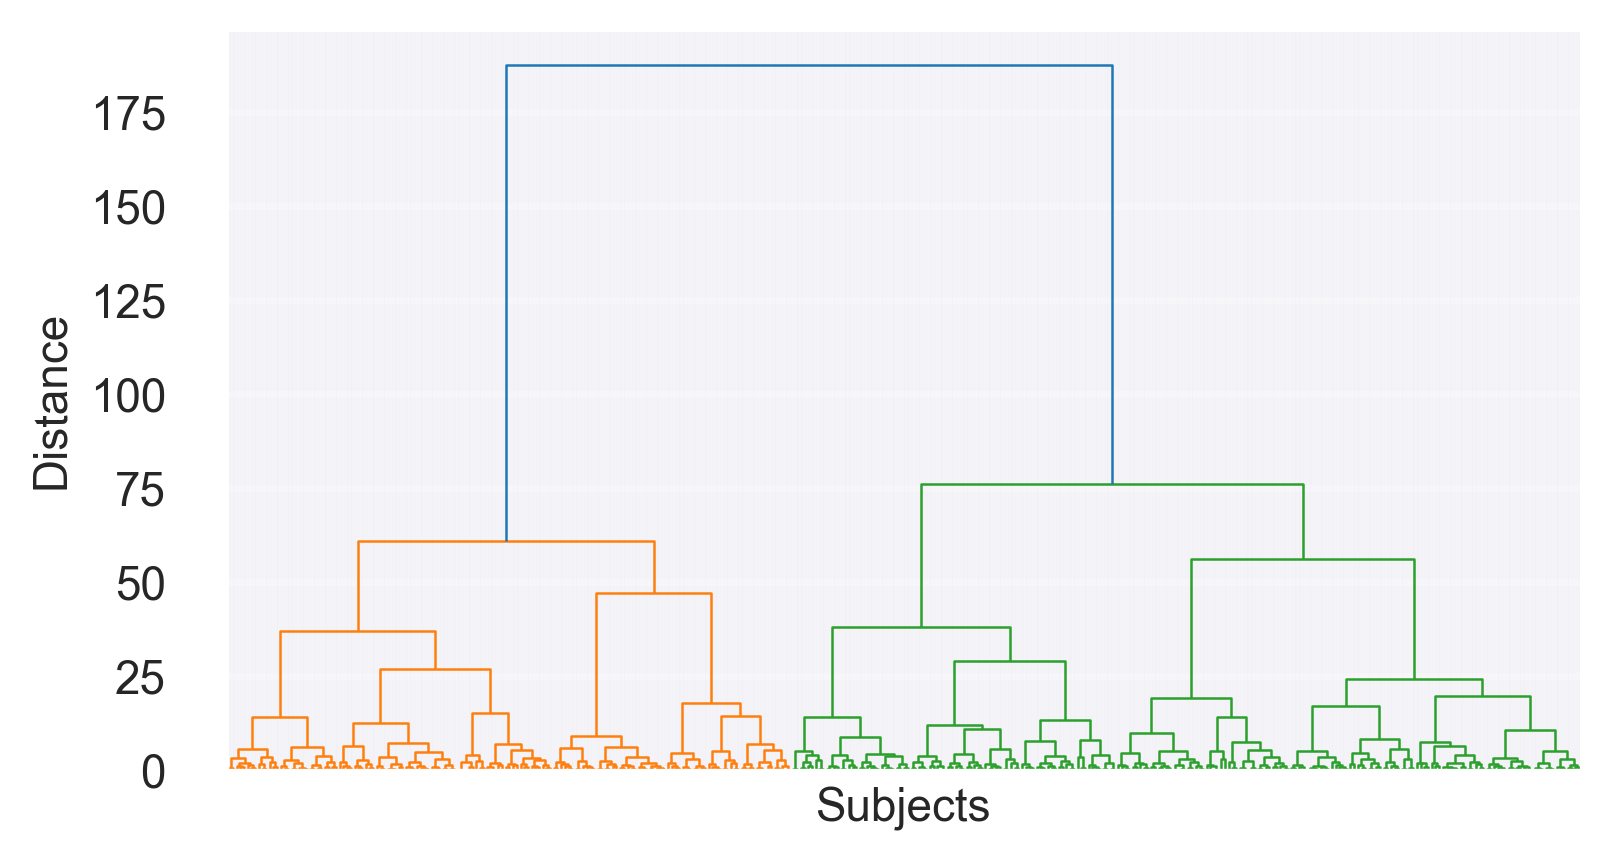

In [146]:
from sklearn.metrics import euclidean_distances
import numpy as np
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

# Step 2: Constructing the dissimilarity matrix
dissimilarity_matrix = euclidean_distances(reduced_data)
print(f"Dissimilarity matrix shape: {dissimilarity_matrix.shape}")

# Assuming 'dissimilarity_matrix' is your uncondensed distance matrix
# Convert the uncondensed distance matrix to a condensed form
condensed_dissimilarity_matrix = squareform(dissimilarity_matrix)
# Step 3: Hierarchical Clustering with Ward's method
# Perform hierarchical clustering using the condensed distance matrix
linkage_matrix = linkage(condensed_dissimilarity_matrix, method='ward')

# Assign initial cluster labels (e.g., 5 clusters)
num_clusters = 5
initial_labels = fcluster(linkage_matrix, t=num_clusters, criterion='maxclust')

# Calculate centroids of each cluster
centroids = np.array([data[initial_labels == i].mean(axis=0) for i in range(1, num_clusters + 1)])

# Compute pairwise distances between centroids
centroid_distances = cdist(centroids, centroids, metric='euclidean')

# Calculate average within-cluster distance
within_cluster_distances = []
for i in range(1, num_clusters + 1):
    cluster_points = data[initial_labels == i]
    pairwise_distances = cdist(cluster_points, cluster_points, metric='euclidean')
    np.fill_diagonal(pairwise_distances, np.nan)  # Ignore diagonal (distance to self)
    avg_distance = np.nanmean(pairwise_distances)
    within_cluster_distances.append(avg_distance)
average_within_cluster_distance = np.mean(within_cluster_distances)

# Set the threshold distance
threshold_distance = 20 * average_within_cluster_distance

# Merge clusters based on centroid distance exceeding the threshold
final_labels = initial_labels.copy()
for i in range(num_clusters):
    for j in range(i + 1, num_clusters):
        if centroid_distances[i, j] < threshold_distance:
            # Merge clusters i and j
            final_labels[initial_labels == j + 1] = i + 1

# Display the final cluster labels
print(f"Number of clusters: {len(np.unique(final_labels))}")
print("Final cluster labels:", final_labels)

# Visualize dendrogram with increased font size
plt.style.use('seaborn-v0_8-poster')
fontsize = 11
plt.rcParams.update({
    "font.size": fontsize,          # Global font size
    "axes.labelsize": fontsize,     # X and Y axis labels
    "axes.titlesize": fontsize,     # Title (if used)
    "xtick.labelsize": fontsize,    # X-axis tick labels
    "ytick.labelsize": fontsize,    # Y-axis tick labels
    "legend.fontsize": fontsize,    # Legend font size
})
fig, ax = plt.subplots(figsize=(5.5, 3), dpi=300)
dendrogram(linkage_matrix)
#plt.title("Hierarchical Clustering Dendrogram", fontsize=fontsize)  # Increase title font size
plt.xlabel("Subjects")  # Increase x-axis label font size
plt.ylabel("Distance")  # Increase y-axis label font size
# Remove x-axis ticks
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.grid(True, alpha=0.3)
ax = plt.gca()
for collection in ax.collections:
    collection.set_linewidth(0.6)  # Reset to default line width
plt.tight_layout()
plt.savefig('dendrogram_high_res.png')  # Save figure with 300 DPI
plt.show()

In [147]:
final_labels

array([2, 2, 1, 4, 4, 2, 3, 2, 1, 1, 1, 1, 2, 1, 1, 3, 1, 3, 2, 4, 4, 2,
       1, 4, 1, 2, 4, 2, 1, 4, 4, 3, 4, 1, 4, 1, 1, 4, 1, 1, 2, 3, 1, 1,
       1, 1, 4, 4, 2, 4, 3, 1, 2, 1, 4, 1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 1,
       2, 2, 1, 4, 3, 1, 1, 1, 1, 1, 1, 3, 1, 2, 2, 3, 1, 1, 4, 1, 3, 4,
       1, 1, 3, 3, 1, 2, 3, 2, 1, 2, 1, 2, 1, 2, 1, 1, 2, 4, 1, 4, 3, 4,
       1, 4, 1, 4, 2, 3, 4, 1, 2, 1, 3, 4, 1, 1, 1, 2, 2, 1, 4, 4, 2, 2,
       4, 4, 2, 2, 4, 2, 1, 1, 4, 4, 2, 1, 1, 2, 4, 1, 4, 1, 1, 1, 4, 4,
       4, 3, 1, 1, 4, 1, 4, 2, 1, 3, 4, 1, 3, 4, 2, 1, 1, 4, 2, 1, 4, 4,
       2, 1, 2, 3, 4, 1, 4, 2, 4, 3, 4, 2, 1, 2, 4, 1, 4, 4, 1, 3, 1, 4,
       4, 4, 1, 3, 2, 1, 2, 3, 2, 2, 1, 2, 1, 2, 2, 4, 3, 2, 3, 4, 1, 4,
       3, 3, 3, 1, 1, 1, 2, 4, 2, 3, 2, 1, 2, 4, 2, 1, 1, 2, 1, 4, 1, 3,
       4, 1, 1, 4, 1, 4, 3, 1, 3, 1, 4, 1, 1, 3, 2, 2, 1, 2, 3, 2, 1, 3,
       1, 4, 4, 2, 1, 1, 3, 1, 4, 1, 2, 2, 1, 1, 1, 3, 2, 2, 1, 1, 1, 1,
       4, 4, 1, 1, 1, 4, 2, 2, 2, 2, 2, 1, 4, 2, 1,

In [219]:
df_CA = df_ah.loc[df_ah['Current_Anxiety']==True].copy()
df_CA['type'] = final_labels

In [149]:
summary_ICD10 = df_CA.groupby(['type', 'ICD10']).size().reset_index(name='count')
print(summary_ICD10)
summary_GAD7 = df_CA.groupby(['type']).agg({'GAD7_score': 'mean'}).reset_index()
print(summary_GAD7)
summary_hospital_current_anxiety = df_CA.groupby('type')['hospital_current_anxiety'].mean().reset_index()
print(summary_hospital_current_anxiety)
summary_Self_Reported_Treatment = df_CA.groupby('type')['Self_Reported_Treatment'].mean().reset_index()
print(summary_Self_Reported_Treatment)
summary_Self_Reported_MentalMedicalCondition = df_CA.groupby('type')['Self_Reported_MentalMedicalCondition'].mean().reset_index()
print(summary_Self_Reported_MentalMedicalCondition)

summary_Age = df_CA.groupby('type')['Age'].mean().reset_index()
print(summary_Age)
summary_Sex = df_CA.groupby('type')['Sex'].mean().reset_index()
print(summary_Sex)
summary_IQ = df_CA.groupby('type')['IQ'].mean().reset_index()
print(summary_IQ)
summary_EA = df_CA.groupby('type')['EA'].mean().reset_index()
print(summary_EA)

    type                     ICD10  count
0      1                  ['F402']      1
1      1                  ['F410']      1
2      1                  ['F411']      1
3      1          ['F412', 'F419']      2
4      1                  ['F412']      2
5      1                  ['F419']     17
6      1                        []    129
7      2          ['F401', 'F411']      1
8      2                  ['F402']      1
9      2                  ['F412']      2
10     2                  ['F419']     16
11     2                        []     68
12     3          ['F402', 'F419']      1
13     3          ['F408', 'F419']      1
14     3  ['F410', 'F412', 'F419']      1
15     3          ['F410', 'F419']      1
16     3                  ['F410']      1
17     3                  ['F419']      3
18     3                        []     39
19     4                  ['F402']      1
20     4          ['F410', 'F419']      1
21     4                  ['F411']      1
22     4          ['F412', 'F419']

In [150]:
summary_ICD10 = df_CA.groupby(['ICD10', 'type']).size().reset_index(name='count')
print(summary_ICD10)

                       ICD10  type  count
0           ['F401', 'F411']     2      1
1           ['F402', 'F419']     3      1
2                   ['F402']     1      1
3                   ['F402']     2      1
4                   ['F402']     4      1
5           ['F408', 'F419']     3      1
6   ['F410', 'F412', 'F419']     3      1
7           ['F410', 'F419']     3      1
8           ['F410', 'F419']     4      1
9                   ['F410']     1      1
10                  ['F410']     3      1
11                  ['F411']     1      1
12                  ['F411']     4      1
13          ['F412', 'F419']     1      2
14          ['F412', 'F419']     4      3
15                  ['F412']     1      2
16                  ['F412']     2      2
17                  ['F412']     4      4
18                  ['F419']     1     17
19                  ['F419']     2     16
20                  ['F419']     3      3
21                  ['F419']     4      5
22                        []     1

Interestingly, type 3 have lower diagnose history and treatment history.
Type 3 were with lower IQ and EA

In [220]:
df_CA = df_CA.merge(participantsInfo_df, on='eid', how='left')

In [221]:
order_list = [1, 2, 3, 4]  # your desired order
df_CA['type'] = pd.Categorical(df_CA['type'], categories=order_list, ordered=True)
df_CA = df_CA.sort_values(by='type')

In [222]:
df_CA.columns

Index(['eid', 'history_anxiety_num_criterias', 'history_anxiety_num_symptoms',
       'history_anxiety', 'GAD7_score', 'Current_Anxiety',
       'Current_no_Anxiety', 'ICD10', 'Diagnosed_ICD10', 'ICD9',
       ...
       'p399_i2_a1', 'p399_i2_a2', 'p399_i2_a3', 'p399_i3_a1', 'p399_i3_a2',
       'p399_i3_a3', 'Factor1', 'Factor2', 'Factor3', 'Factor4'],
      dtype='object', length=666)

In [223]:
summary_kdm_acceleration = df_CA.groupby(['type'])['Factor1'].describe()
print(summary_kdm_acceleration)
types = df_CA['type'].unique()
for typeID in types:
    values = df_CA.loc[df_CA['type'] == typeID, 'Factor1'].dropna()
    n = len(values)

    print(f"\nType: {typeID}")

    if n >= 2:
        t_stat, p_value = stats.ttest_1samp(values, popmean=0)
        print(f"t = {round(t_stat, 3)}; df = {n - 1}; p = {round(p_value, 3)}")
    else:
        print("Not enough valid data for t-test.")
import pingouin as pg
pairwise = pg.pairwise_tests(dv='Factor1', between='type', data=df_CA)
df_t_test = pairwise[['A', 'B', 'T', 'dof', 'p-unc']]
df_t_test.columns = ['A', 'B', 't', 'df', 'p_unc']
df_t_test['t'] = df_t_test['t'].round(3)
df_t_test['p_unc'] = df_t_test['p_unc'].round(3)
df_t_test['df'] = df_t_test['df'].round(0)
print(df_t_test)

      count        mean         std     min        25%      50%        75%  \
type                                                                         
1      97.0  146.074742  120.992116  76.875  107.62500  122.534  150.06000   
2      55.0  135.217782   44.681633  71.340  111.00750  130.380  145.78750   
3      30.0  161.913600   81.559218  98.400  115.34975  137.760  165.58875   
4      53.0  128.933717   39.884870   0.000  109.47000  120.540  140.22000   

           max  
type            
1     1242.067  
2      325.465  
3      515.370  
4      278.660  

Type: 1
t = 11.891; df = 96; p = 0.0

Type: 2
t = 22.443; df = 54; p = 0.0

Type: 3
t = 10.874; df = 29; p = 0.0

Type: 4
t = 23.534; df = 52; p = 0.0
   A  B      t     df  p_unc
0  1  2  0.793  134.0  0.429
1  1  3 -0.820   72.0  0.415
2  1  4  1.274  129.0  0.205
3  2  3 -1.662   39.0  0.105
4  2  4  0.772  105.0  0.442
5  3  4  2.079   37.0  0.045


/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_4428/3870417573.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_kdm_acceleration = df_CA.groupby(['type'])['Factor1'].describe()
/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_4428/3870417573.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t_test['t'] = df_t_test['t'].round(3)
/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_4428/3870417573.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

In [224]:
summary_kdm_acceleration = df_CA.groupby(['type'])['Factor2'].describe()
print(summary_kdm_acceleration)
types = df_CA['type'].unique()
for typeID in types:
    values = df_CA.loc[df_CA['type'] == typeID, 'Factor2'].dropna()
    n = len(values)

    print(f"\nType: {typeID}")

    if n >= 2:
        t_stat, p_value = stats.ttest_1samp(values, popmean=0)
        print(f"t = {round(t_stat, 3)}; df = {n - 1}; p = {round(p_value, 3)}")
    else:
        print("Not enough valid data for t-test.")
import pingouin as pg
pairwise = pg.pairwise_tests(dv='Factor2', between='type', data=df_CA)
df_t_test = pairwise[['A', 'B', 'T', 'dof', 'p-unc']]
df_t_test.columns = ['A', 'B', 't', 'df', 'p_unc']
df_t_test['t'] = df_t_test['t'].round(3)
df_t_test['p_unc'] = df_t_test['p_unc'].round(3)
df_t_test['df'] = df_t_test['df'].round(0)
print(df_t_test)

      count        mean         std      min       25%      50%      75%  \
type                                                                       
1      97.0  527.897588  250.045335    0.000  390.7300  466.970  592.766   
2      55.0  525.092327  264.264286    3.852  380.2470  463.061  568.670   
3      30.0  658.802067  346.625704  323.067  424.8825  540.371  752.666   
4      53.0  464.143415  199.225164    0.000  395.9230  462.205  527.962   

           max  
type            
1     1821.029  
2     1541.743  
3     1590.363  
4     1212.119  

Type: 1
t = 20.793; df = 96; p = 0.0

Type: 2
t = 14.736; df = 54; p = 0.0

Type: 3
t = 10.41; df = 29; p = 0.0

Type: 4
t = 16.961; df = 52; p = 0.0
   A  B      t     df  p_unc
0  1  2  0.064  107.0  0.949
1  1  3 -1.920   39.0  0.062
2  1  4  1.708  128.0  0.090
3  2  3 -1.841   48.0  0.072
4  2  4  1.357  100.0  0.178
5  3  4  2.823   40.0  0.007


/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_4428/1061164602.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_kdm_acceleration = df_CA.groupby(['type'])['Factor2'].describe()
/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_4428/1061164602.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t_test['t'] = df_t_test['t'].round(3)
/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_4428/1061164602.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

In [225]:
summary_kdm_acceleration = df_CA.groupby(['type'])['Factor3'].describe()
print(summary_kdm_acceleration)
types = df_CA['type'].unique()
for typeID in types:
    values = df_CA.loc[df_CA['type'] == typeID, 'Factor3'].dropna()
    n = len(values)

    print(f"\nType: {typeID}")

    if n >= 2:
        t_stat, p_value = stats.ttest_1samp(values, popmean=0)
        print(f"t = {round(t_stat, 3)}; df = {n - 1}; p = {round(p_value, 3)}")
    else:
        print("Not enough valid data for t-test.")
import pingouin as pg
pairwise = pg.pairwise_tests(dv='Factor3', between='type', data=df_CA)
df_t_test = pairwise[['A', 'B', 'T', 'dof', 'p-unc']]
df_t_test.columns = ['A', 'B', 't', 'df', 'p_unc']
df_t_test['t'] = df_t_test['t'].round(3)
df_t_test['p_unc'] = df_t_test['p_unc'].round(3)
df_t_test['df'] = df_t_test['df'].round(0)
print(df_t_test)

      count       mean       std    min       25%      50%       75%     max
type                                                                        
1      94.0  14.166787  2.871746  6.329  12.29550  14.2285  16.33950  21.822
2      55.0  13.895073  2.452547  9.496  12.44150  13.7450  15.45650  21.674
3      29.0  13.244931  2.564483  6.950  12.09500  13.6680  14.82000  17.994
4      50.0  13.866240  2.452457  8.547  11.86675  14.5945  15.34525  19.511

Type: 1
t = 47.829; df = 93; p = 0.0

Type: 2
t = 42.017; df = 54; p = 0.0

Type: 3
t = 27.813; df = 28; p = 0.0

Type: 4
t = 39.98; df = 49; p = 0.0
   A  B      t     df  p_unc
0  1  2  0.612  128.0  0.542
1  1  3  1.644   52.0  0.106
2  1  4  0.659  114.0  0.511
3  2  3  1.121   55.0  0.267
4  2  4  0.060  102.0  0.952
5  3  4 -1.055   56.0  0.296


/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_4428/592922087.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_kdm_acceleration = df_CA.groupby(['type'])['Factor3'].describe()
/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_4428/592922087.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t_test['t'] = df_t_test['t'].round(3)
/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_4428/592922087.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

In [226]:
summary_kdm_acceleration = df_CA.groupby(['type'])['Factor4'].describe()
print(summary_kdm_acceleration)
types = df_CA['type'].unique()
for typeID in types:
    values = df_CA.loc[df_CA['type'] == typeID, 'Factor4'].dropna()
    n = len(values)

    print(f"\nType: {typeID}")

    if n >= 2:
        t_stat, p_value = stats.ttest_1samp(values, popmean=0)
        print(f"t = {round(t_stat, 3)}; df = {n - 1}; p = {round(p_value, 3)}")
    else:
        print("Not enough valid data for t-test.")
import pingouin as pg
pairwise = pg.pairwise_tests(dv='Factor4', between='type', data=df_CA)
df_t_test = pairwise[['A', 'B', 'T', 'dof', 'p-unc']]
df_t_test.columns = ['A', 'B', 't', 'df', 'p_unc']
df_t_test['t'] = df_t_test['t'].round(3)
df_t_test['p_unc'] = df_t_test['p_unc'].round(3)
df_t_test['df'] = df_t_test['df'].round(0)
print(df_t_test)

      count        mean        std      min      25%      50%       75%  \
type                                                                      
1      97.0  310.439237  95.498085  213.484  266.272  297.742  321.0220   
2      55.0  298.272982  50.595893  207.436  262.990  292.124  319.0910   
3      30.0  330.213533  85.506060  239.166  270.514  321.783  351.3780   
4      52.0  299.577500  46.685615  218.274  264.246  299.358  318.3015   

           max  
type            
1     1095.112  
2      397.950  
3      646.876  
4      442.082  

Type: 1
t = 32.016; df = 96; p = 0.0

Type: 2
t = 43.72; df = 54; p = 0.0

Type: 3
t = 21.152; df = 29; p = 0.0

Type: 4
t = 46.273; df = 51; p = 0.0
   A  B      t     df  p_unc
0  1  2  1.026  149.0  0.306
1  1  3 -1.076   53.0  0.287
2  1  4  0.932  146.0  0.353
3  2  3 -1.875   40.0  0.068
4  2  4 -0.139  105.0  0.890
5  3  4  1.813   39.0  0.078


/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_4428/2903209937.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_kdm_acceleration = df_CA.groupby(['type'])['Factor4'].describe()
/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_4428/2903209937.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t_test['t'] = df_t_test['t'].round(3)
/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_4428/2903209937.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

In [153]:
from scipy import stats
summary_kdm_acceleration = df_CA.groupby(['type'])['kdm_acceleration_InitialAssessmentVisit'].describe()
print(summary_kdm_acceleration)
types = df_CA['type'].unique()
for typeID in types:
    values = df_CA.loc[df_CA['type'] == typeID, 'kdm_acceleration_InitialAssessmentVisit'].dropna()
    n = len(values)

    print(f"\nType: {typeID}")

    if n >= 2:
        t_stat, p_value = stats.ttest_1samp(values, popmean=0)
        print(f"t = {round(t_stat, 3)}; df = {n - 1}; p = {round(p_value, 3)}")
    else:
        print("Not enough valid data for t-test.")
import pingouin as pg
pairwise = pg.pairwise_tests(dv='kdm_acceleration_InitialAssessmentVisit', between='type', data=df_CA)
df_t_test = pairwise[['A', 'B', 'T', 'dof', 'p-unc']]
df_t_test.columns = ['A', 'B', 't', 'df', 'p_unc']
df_t_test['t'] = df_t_test['t'].round(3)
df_t_test['p_unc'] = df_t_test['p_unc'].round(3)
df_t_test['df'] = df_t_test['df'].round(0)
print(df_t_test)

      count      mean       std        min       25%       50%       75%  \
type                                                                       
1      25.0  0.200293  5.729480  -8.066928 -2.567701 -1.514627  2.212794   
2      13.0 -0.715436  4.532119  -9.201439 -2.755675  0.573858  1.718255   
3       8.0  0.671975  5.090902  -5.943219 -2.490390  0.990564  2.318443   
4      12.0 -2.612425  6.124281 -20.324620 -2.910001 -1.830503 -0.307050   

            max  
type             
1     14.100280  
2      6.885820  
3      9.712394  
4      4.545902  

Type: 1
t = 0.175; df = 24; p = 0.863

Type: 2
t = -0.569; df = 12; p = 0.58

Type: 3
t = 0.373; df = 7; p = 0.72

Type: 4
t = -1.478; df = 11; p = 0.168
   A  B      t    df  p_unc
0  1  2  0.538  30.0  0.594
1  1  3 -0.221  13.0  0.828
2  1  4  1.335  21.0  0.196
3  2  3 -0.632  14.0  0.538
4  2  4  0.874  20.0  0.392
5  3  4  1.302  17.0  0.210


/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_4428/708380121.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_kdm_acceleration = df_CA.groupby(['type'])['kdm_acceleration_InitialAssessmentVisit'].describe()
/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_4428/708380121.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t_test['t'] = df_t_test['t'].round(3)
/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_4428/708380121.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

In [157]:
from scipy import stats
summary_kdm_acceleration = df_CA.groupby(['type'])['kdm_acceleration_RepeatAssessmentVisit'].describe()
print(summary_kdm_acceleration)
types = df_CA['type'].unique()
for typeID in types:
    values = df_CA.loc[df_CA['type'] == typeID, 'kdm_acceleration_RepeatAssessmentVisit'].dropna()
    n = len(values)

    print(f"\nType: {typeID}")

    if n >= 2:
        t_stat, p_value = stats.ttest_1samp(values, popmean=0)
        print(f"t = {round(t_stat, 3)}; df = {n - 1}; p = {round(p_value, 3)}")
    else:
        print("Not enough valid data for t-test.")
import pingouin as pg
pairwise = pg.pairwise_tests(dv='kdm_acceleration_RepeatAssessmentVisit', between='type', data=df_CA)
df_t_test = pairwise[['A', 'B', 'T', 'dof', 'p-unc']]
df_t_test.columns = ['A', 'B', 't', 'df', 'p_unc']
df_t_test['t'] = df_t_test['t'].round(3)
df_t_test['p_unc'] = df_t_test['p_unc'].round(3)
df_t_test['df'] = df_t_test['df'].round(0)
print(df_t_test)

      count      mean       std        min       25%       50%       75%  \
type                                                                       
1       3.0 -2.279190  7.626611 -10.238081 -5.901184 -1.564287  1.700256   
2       0.0       NaN       NaN        NaN       NaN       NaN       NaN   
3       0.0       NaN       NaN        NaN       NaN       NaN       NaN   
4       2.0 -5.726465  8.392189 -11.660639 -8.693552 -5.726465 -2.759378   

           max  
type            
1     4.964798  
2          NaN  
3          NaN  
4     0.207709  

Type: 1
t = -0.518; df = 2; p = 0.656

Type: 2
Not enough valid data for t-test.

Type: 3
Not enough valid data for t-test.

Type: 4
t = -0.965; df = 1; p = 0.511


/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_4428/4012006331.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_kdm_acceleration = df_CA.groupby(['type'])['kdm_acceleration_RepeatAssessmentVisit'].describe()


AssertionError: y cannot be an empty list or array.

In [160]:
summary_kdm_acceleration = df_CA.groupby(['type'])['GAD_baseline'].describe()
print(summary_kdm_acceleration)
types = df_CA['type'].unique()
pairwise = pg.pairwise_tests(dv='GAD_baseline', between='type', data=df_CA)
df_t_test = pairwise[['A', 'B', 'T', 'dof', 'p-unc']]
df_t_test.columns = ['A', 'B', 't', 'df', 'p_unc']
df_t_test['t'] = df_t_test['t'].round(3)
df_t_test['p_unc'] = df_t_test['p_unc'].round(3)
df_t_test['df'] = df_t_test['df'].round(0)
print(df_t_test)

      count       mean       std   min   25%   50%    75%   max
type                                                           
1      37.0  14.189189  3.777402  10.0  11.0  12.0  18.00  21.0
2      20.0  13.400000  2.741494  10.0  11.0  13.0  14.25  19.0
3       9.0  14.888889  3.789606  11.0  12.0  13.0  19.00  21.0
4      16.0  12.937500  2.792102  10.0  10.0  13.0  14.25  18.0
   A  B      t    df  p_unc
0  1  2  0.904  50.0  0.370
1  1  3 -0.497  12.0  0.628
2  1  4  1.340  38.0  0.188
3  2  3 -1.060  12.0  0.310
4  2  4  0.498  32.0  0.622
5  3  4  1.352  13.0  0.199


/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_4428/4041536166.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_kdm_acceleration = df_CA.groupby(['type'])['GAD_baseline'].describe()
/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_4428/4041536166.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t_test['t'] = df_t_test['t'].round(3)
/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_4428/4041536166.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [161]:
summary_kdm_acceleration = df_CA.groupby(['type'])['GAD_followup'].describe()
print(summary_kdm_acceleration)
types = df_CA['type'].unique()
pairwise = pg.pairwise_tests(dv='GAD_followup', between='type', data=df_CA)
df_t_test = pairwise[['A', 'B', 'T', 'dof', 'p-unc']]
df_t_test.columns = ['A', 'B', 't', 'df', 'p_unc']
df_t_test['t'] = df_t_test['t'].round(3)
df_t_test['p_unc'] = df_t_test['p_unc'].round(3)
df_t_test['df'] = df_t_test['df'].round(0)
print(df_t_test)

      count      mean       std  min  25%   50%    75%   max
type                                                        
1      25.0  9.640000  6.061353  0.0  4.0  10.0  14.00  19.0
2      14.0  7.214286  5.950806  0.0  2.5   7.0  10.25  20.0
3       6.0  8.666667  7.089899  1.0  3.0   7.5  14.25  18.0
4      14.0  8.500000  6.560371  0.0  3.5   6.5  13.75  20.0
   A  B      t    df  p_unc
0  1  2  1.213  27.0  0.235
1  1  3  0.310   7.0  0.766
2  1  4  0.535  25.0  0.597
3  2  3 -0.440   8.0  0.671
4  2  4 -0.543  26.0  0.592
5  3  4  0.049   9.0  0.962


/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_4428/2267150917.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_kdm_acceleration = df_CA.groupby(['type'])['GAD_followup'].describe()
/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_4428/2267150917.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t_test['t'] = df_t_test['t'].round(3)
/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_4428/2267150917.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [163]:
summary_kdm_acceleration = df_CA.groupby(['type'])['GAD7_diff'].describe()
print(summary_kdm_acceleration)
pairwise = pg.pairwise_tests(dv='GAD7_diff', between='type', data=df_CA)
df_t_test = pairwise[['A', 'B', 'T', 'dof', 'p-unc']]
df_t_test.columns = ['A', 'B', 't', 'df', 'p_unc']
df_t_test['t'] = df_t_test['t'].round(3)
df_t_test['p_unc'] = df_t_test['p_unc'].round(3)
df_t_test['df'] = df_t_test['df'].round(0)
print(df_t_test)

      count      mean       std   min   25%  50%   75%  max
type                                                       
1      25.0 -4.760000  5.967132 -15.0  -8.0 -4.0 -1.00  7.0
2      14.0 -6.357143  6.233990 -14.0 -10.0 -6.5 -3.00  9.0
3       6.0 -6.000000  7.589466 -18.0  -9.5 -4.0 -3.00  4.0
4      14.0 -4.571429  5.459139 -14.0  -7.0 -4.5  0.25  3.0
   A  B      t    df  p_unc
0  1  2  0.779  26.0  0.443
1  1  3  0.373   7.0  0.721
2  1  4 -0.100  29.0  0.921
3  2  3 -0.102   8.0  0.922
4  2  4 -0.806  26.0  0.427
5  3  4 -0.417   7.0  0.689


/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_4428/2094467840.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_kdm_acceleration = df_CA.groupby(['type'])['GAD7_diff'].describe()
/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_4428/2094467840.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t_test['t'] = df_t_test['t'].round(3)
/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_4428/2094467840.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

In [209]:
summary_kdm_acceleration = df_CA.groupby(['type'])['worry_1'].describe()
print(summary_kdm_acceleration)
pairwise = pg.pairwise_tests(dv='worry_1', between='type', data=df_CA)
df_t_test = pairwise[['A', 'B', 'T', 'dof', 'p-unc']]
df_t_test.columns = ['A', 'B', 't', 'df', 'p_unc']
df_t_test['t'] = df_t_test['t'].round(3)
df_t_test['p_unc'] = df_t_test['p_unc'].round(3)
df_t_test['df'] = df_t_test['df'].round(0)
print(df_t_test)

      count      mean       std  min   25%  50%  75%  max
type                                                     
1     153.0  1.176471  0.778981 -1.0  1.00  1.0  2.0  2.0
2      88.0  1.159091  0.800666  0.0  0.75  1.0  2.0  2.0
3      47.0  1.021277  0.793708  0.0  0.00  1.0  2.0  2.0
4      79.0  1.164557  0.723779  0.0  1.00  1.0  2.0  2.0
   A  B      t     df  p_unc
0  1  2  0.164  177.0  0.870
1  1  3  1.178   75.0  0.243
2  1  4  0.116  168.0  0.908
3  2  3  0.958   95.0  0.340
4  2  4 -0.046  165.0  0.963
5  3  4 -1.012   90.0  0.314


/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_4428/1625694795.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_kdm_acceleration = df_CA.groupby(['type'])['worry_1'].describe()
/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_4428/1625694795.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t_test['t'] = df_t_test['t'].round(3)
/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_4428/1625694795.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

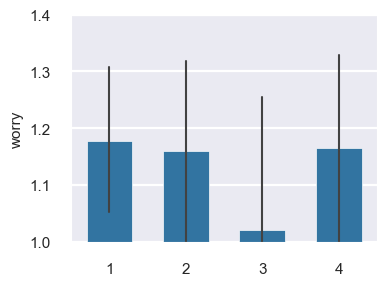

In [217]:
fig, ax = plt.subplots(figsize=(4, 3))  # or adjust figsize as needed
sns.barplot(
    data=df_CA,
    x='type',
    y='worry_1',
    #order=sessionID_all_names,
    width=0.6,
    err_kws={'linewidth': 1.5},
    ax=ax
)

ax.set_ylim(1, 1.4)
ax.set_xlabel('')
ax.set_ylabel('worry')

plt.tight_layout()
plt.show()

In [210]:
summary_kdm_acceleration = df_CA.groupby(['type'])['worry_2'].describe()
print(summary_kdm_acceleration)
pairwise = pg.pairwise_tests(dv='worry_2', between='type', data=df_CA)
df_t_test = pairwise[['A', 'B', 'T', 'dof', 'p-unc']]
df_t_test.columns = ['A', 'B', 't', 'df', 'p_unc']
df_t_test['t'] = df_t_test['t'].round(3)
df_t_test['p_unc'] = df_t_test['p_unc'].round(3)
df_t_test['df'] = df_t_test['df'].round(0)
print(df_t_test)

      count      mean       std  min   25%  50%  75%  max
type                                                     
1      23.0  1.434783  0.727767  0.0  1.00  2.0  2.0  2.0
2       8.0  1.375000  0.916125  0.0  0.75  2.0  2.0  2.0
3      14.0  1.285714  0.726273  0.0  1.00  1.0  2.0  2.0
4      14.0  1.142857  0.770329  0.0  1.00  1.0  2.0  2.0
   A  B      t    df  p_unc
0  1  2  0.167  10.0  0.871
1  1  3  0.605  28.0  0.550
2  1  4  1.141  26.0  0.264
3  2  3  0.236  12.0  0.817
4  2  4  0.605  13.0  0.556
5  3  4  0.505  26.0  0.618


/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_4428/4255657893.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_kdm_acceleration = df_CA.groupby(['type'])['worry_2'].describe()
/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_4428/4255657893.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t_test['t'] = df_t_test['t'].round(3)
/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_4428/4255657893.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

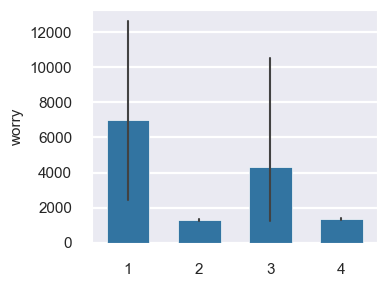

In [211]:
summary_kdm_acceleration = df_CA.groupby(['type'])['worry_3'].describe()
print(summary_kdm_acceleration)
pairwise = pg.pairwise_tests(dv='worry_3', between='type', data=df_CA)
df_t_test = pairwise[['A', 'B', 'T', 'dof', 'p-unc']]
df_t_test.columns = ['A', 'B', 't', 'df', 'p_unc']
df_t_test['t'] = df_t_test['t'].round(3)
df_t_test['p_unc'] = df_t_test['p_unc'].round(3)
df_t_test['df'] = df_t_test['df'].round(0)
print(df_t_test)

      count      mean       std  min  25%  50%  75%  max
type                                                    
1     153.0  1.248366  0.780360 -2.0  1.0  1.0  2.0  2.0
2      88.0  1.250000  0.715188  0.0  1.0  1.0  2.0  2.0
3      47.0  1.170213  0.760982  0.0  1.0  1.0  2.0  2.0
4      79.0  1.341772  0.677213  0.0  1.0  1.0  2.0  2.0
   A  B      t     df  p_unc
0  1  2 -0.017  195.0  0.987
1  1  3  0.612   78.0  0.542
2  1  4 -0.944  179.0  0.346
3  2  3  0.593   89.0  0.555
4  2  4 -0.851  165.0  0.396
5  3  4 -1.274   88.0  0.206


/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_4428/69305692.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_kdm_acceleration = df_CA.groupby(['type'])['worry_3'].describe()
/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_4428/69305692.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t_test['t'] = df_t_test['t'].round(3)
/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_4428/69305692.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

In [212]:
summary_kdm_acceleration = df_CA.groupby(['type'])['worry_4'].describe()
print(summary_kdm_acceleration)
pairwise = pg.pairwise_tests(dv='worry_4', between='type', data=df_CA)
df_t_test = pairwise[['A', 'B', 'T', 'dof', 'p-unc']]
df_t_test.columns = ['A', 'B', 't', 'df', 'p_unc']
df_t_test['t'] = df_t_test['t'].round(3)
df_t_test['p_unc'] = df_t_test['p_unc'].round(3)
df_t_test['df'] = df_t_test['df'].round(0)
print(df_t_test)

      count      mean       std  min  25%  50%  75%  max
type                                                    
1      33.0  1.242424  0.708445  0.0  1.0  1.0  2.0  2.0
2       9.0  1.444444  0.726483  0.0  1.0  2.0  2.0  2.0
3       7.0  1.142857  0.690066  0.0  1.0  1.0  1.5  2.0
4      13.0  1.384615  0.650444  0.0  1.0  1.0  2.0  2.0
   A  B      t    df  p_unc
0  1  2 -0.743  12.0  0.471
1  1  3  0.345   9.0  0.738
2  1  4 -0.651  24.0  0.521
3  2  3  0.847  13.0  0.412
4  2  4  0.198  16.0  0.845
5  3  4 -0.762  12.0  0.461


/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_4428/3244536662.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_kdm_acceleration = df_CA.groupby(['type'])['worry_4'].describe()
/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_4428/3244536662.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t_test['t'] = df_t_test['t'].round(3)
/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_4428/3244536662.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

In [171]:
summary_kdm_acceleration = df_CA.groupby(['type'])['neuroticism_1'].describe()
print(summary_kdm_acceleration)
pairwise = pg.pairwise_tests(dv='neuroticism_1', between='type', data=df_CA)
df_t_test = pairwise[['A', 'B', 'T', 'dof', 'p-unc']]
df_t_test.columns = ['A', 'B', 't', 'df', 'p_unc']
df_t_test['t'] = df_t_test['t'].round(3)
df_t_test['p_unc'] = df_t_test['p_unc'].round(3)
df_t_test['df'] = df_t_test['df'].round(0)
print(df_t_test)

      count      mean       std  min  25%  50%  75%  max
type                                                    
1     153.0  0.620915  0.538108 -1.0  0.0  1.0  1.0  1.0
2      88.0  0.602273  0.536908 -1.0  0.0  1.0  1.0  1.0
3      47.0  0.638298  0.528556 -1.0  0.0  1.0  1.0  1.0
4      79.0  0.645570  0.481397  0.0  0.0  1.0  1.0  1.0
   A  B      t     df  p_unc
0  1  2  0.259  182.0  0.796
1  1  3 -0.196   78.0  0.845
2  1  4 -0.355  174.0  0.723
3  2  3 -0.375   95.0  0.708
4  2  4 -0.549  165.0  0.583
5  3  4 -0.077   90.0  0.939


/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_4428/3785723903.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_kdm_acceleration = df_CA.groupby(['type'])['neuroticism_1'].describe()
/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_4428/3785723903.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t_test['t'] = df_t_test['t'].round(3)
/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_4428/3785723903.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

In [172]:
summary_kdm_acceleration = df_CA.groupby(['type'])['neuroticism_2'].describe()
print(summary_kdm_acceleration)
pairwise = pg.pairwise_tests(dv='neuroticism_2', between='type', data=df_CA)
df_t_test = pairwise[['A', 'B', 'T', 'dof', 'p-unc']]
df_t_test.columns = ['A', 'B', 't', 'df', 'p_unc']
df_t_test['t'] = df_t_test['t'].round(3)
df_t_test['p_unc'] = df_t_test['p_unc'].round(3)
df_t_test['df'] = df_t_test['df'].round(0)
print(df_t_test)

      count      mean       std  min   25%  50%  75%  max
type                                                     
1      23.0  0.782609  0.421741  0.0  1.00  1.0  1.0  1.0
2       8.0  0.375000  0.517549  0.0  0.00  0.0  1.0  1.0
3      14.0  0.714286  0.468807  0.0  0.25  1.0  1.0  1.0
4      14.0  0.571429  0.513553  0.0  0.00  1.0  1.0  1.0
   A  B      t    df  p_unc
0  1  2  2.008  10.0  0.071
1  1  3  0.446  25.0  0.659
2  1  4  1.296  24.0  0.208
3  2  3 -1.530  14.0  0.149
4  2  4 -0.859  15.0  0.404
5  3  4  0.769  26.0  0.449


/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_4428/1969022108.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_kdm_acceleration = df_CA.groupby(['type'])['neuroticism_2'].describe()
/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_4428/1969022108.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t_test['t'] = df_t_test['t'].round(3)
/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_4428/1969022108.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

In [170]:
summary_kdm_acceleration = df_CA.groupby(['type'])['neuroticism_3'].describe()
print(summary_kdm_acceleration)
pairwise = pg.pairwise_tests(dv='neuroticism_3', between='type', data=df_CA)
df_t_test = pairwise[['A', 'B', 'T', 'dof', 'p-unc']]
df_t_test.columns = ['A', 'B', 't', 'df', 'p_unc']
df_t_test['t'] = df_t_test['t'].round(3)
df_t_test['p_unc'] = df_t_test['p_unc'].round(3)
df_t_test['df'] = df_t_test['df'].round(0)
print(df_t_test)

      count      mean       std  min  25%  50%  75%  max
type                                                    
1     153.0  0.666667  0.486664 -1.0  0.0  1.0  1.0  1.0
2      88.0  0.636364  0.550482 -1.0  0.0  1.0  1.0  1.0
3      47.0  0.680851  0.515262 -1.0  0.0  1.0  1.0  1.0
4      79.0  0.645570  0.620958 -3.0  0.0  1.0  1.0  1.0
   A  B      t     df  p_unc
0  1  2  0.429  164.0  0.669
1  1  3 -0.167   73.0  0.868
2  1  4  0.263  129.0  0.793
3  2  3 -0.467  100.0  0.642
4  2  4 -0.101  157.0  0.920
5  3  4  0.344  111.0  0.732


/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_4428/2966051010.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_kdm_acceleration = df_CA.groupby(['type'])['neuroticism_3'].describe()
/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_4428/2966051010.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t_test['t'] = df_t_test['t'].round(3)
/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_4428/2966051010.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

In [173]:
summary_kdm_acceleration = df_CA.groupby(['type'])['neuroticism_4'].describe()
print(summary_kdm_acceleration)
pairwise = pg.pairwise_tests(dv='neuroticism_4', between='type', data=df_CA)
df_t_test = pairwise[['A', 'B', 'T', 'dof', 'p-unc']]
df_t_test.columns = ['A', 'B', 't', 'df', 'p_unc']
df_t_test['t'] = df_t_test['t'].round(3)
df_t_test['p_unc'] = df_t_test['p_unc'].round(3)
df_t_test['df'] = df_t_test['df'].round(0)
print(df_t_test)

      count      mean       std  min  25%  50%  75%  max
type                                                    
1      33.0  0.727273  0.452267  0.0  0.0  1.0  1.0  1.0
2       9.0  0.666667  0.500000  0.0  0.0  1.0  1.0  1.0
3       7.0  0.571429  0.786796 -1.0  0.5  1.0  1.0  1.0
4      13.0  0.923077  0.277350  0.0  1.0  1.0  1.0  1.0
   A  B      t    df  p_unc
0  1  2  0.329  12.0  0.748
1  1  3  0.507   7.0  0.628
2  1  4 -1.779  36.0  0.084
3  2  3  0.279  10.0  0.786
4  2  4 -1.397  11.0  0.189
5  3  4 -1.145   7.0  0.291


/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_4428/89010959.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_kdm_acceleration = df_CA.groupby(['type'])['neuroticism_4'].describe()
/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_4428/89010959.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t_test['t'] = df_t_test['t'].round(3)
/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_4428/89010959.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

In [174]:
summary_kdm_acceleration = df_CA.groupby(['type'])['NumericMemoryTest_1'].describe()
print(summary_kdm_acceleration)
pairwise = pg.pairwise_tests(dv='NumericMemoryTest_1', between='type', data=df_CA)
df_t_test = pairwise[['A', 'B', 'T', 'dof', 'p-unc']]
df_t_test.columns = ['A', 'B', 't', 'df', 'p_unc']
df_t_test['t'] = df_t_test['t'].round(3)
df_t_test['p_unc'] = df_t_test['p_unc'].round(3)
df_t_test['df'] = df_t_test['df'].round(0)
print(df_t_test)

      count      mean       std  min  25%  50%  75%  max
type                                                    
1      11.0  6.727273  1.009050  6.0  6.0  6.0  7.0  9.0
2       9.0  6.444444  1.424001  4.0  6.0  6.0  8.0  8.0
3       8.0  5.500000  2.672612 -1.0  6.0  6.0  7.0  7.0
4       9.0  6.555556  1.424001  5.0  5.0  7.0  7.0  9.0
   A  B      t    df  p_unc
0  1  2  0.502  14.0  0.624
1  1  3  1.236   8.0  0.250
2  1  4  0.305  14.0  0.765
3  2  3  0.893  10.0  0.392
4  2  4 -0.166  16.0  0.871
5  3  4 -0.998  10.0  0.341


/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_4428/3423270354.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_kdm_acceleration = df_CA.groupby(['type'])['NumericMemoryTest_1'].describe()
/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_4428/3423270354.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t_test['t'] = df_t_test['t'].round(3)
/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_4428/3423270354.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

In [176]:
summary_kdm_acceleration = df_CA.groupby(['type'])['NumericMemoryTest_3'].describe()
print(summary_kdm_acceleration)
pairwise = pg.pairwise_tests(dv='NumericMemoryTest_3', between='type', data=df_CA)
df_t_test = pairwise[['A', 'B', 'T', 'dof', 'p-unc']]
df_t_test.columns = ['A', 'B', 't', 'df', 'p_unc']
df_t_test['t'] = df_t_test['t'].round(3)
df_t_test['p_unc'] = df_t_test['p_unc'].round(3)
df_t_test['df'] = df_t_test['df'].round(0)
print(df_t_test)

      count      mean       std  min  25%  50%  75%   max
type                                                     
1      99.0  6.696970  1.289317  3.0  6.0  7.0  7.0  10.0
2      58.0  6.775862  1.600911 -1.0  6.0  7.0  7.0  10.0
3      31.0  6.387097  1.909231 -1.0  6.0  6.0  7.0  11.0
4      54.0  6.611111  1.907450 -1.0  6.0  7.0  8.0   9.0
   A  B      t     df  p_unc
0  1  2 -0.319  100.0  0.750
1  1  3  0.845   39.0  0.403
2  1  4  0.296   80.0  0.768
3  2  3  0.967   53.0  0.338
4  2  4  0.493  104.0  0.623
5  3  4 -0.521   63.0  0.604


/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_4428/767864107.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_kdm_acceleration = df_CA.groupby(['type'])['NumericMemoryTest_3'].describe()
/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_4428/767864107.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t_test['t'] = df_t_test['t'].round(3)
/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_4428/767864107.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

In [177]:
summary_kdm_acceleration = df_CA.groupby(['type'])['NumericMemoryTest_4'].describe()
print(summary_kdm_acceleration)
pairwise = pg.pairwise_tests(dv='NumericMemoryTest_4', between='type', data=df_CA)
df_t_test = pairwise[['A', 'B', 'T', 'dof', 'p-unc']]
df_t_test.columns = ['A', 'B', 't', 'df', 'p_unc']
df_t_test['t'] = df_t_test['t'].round(3)
df_t_test['p_unc'] = df_t_test['p_unc'].round(3)
df_t_test['df'] = df_t_test['df'].round(0)
print(df_t_test)

      count      mean       std  min   25%  50%  75%  max
type                                                     
1      27.0  6.259259  1.972749 -1.0  6.00  6.0  8.0  9.0
2       8.0  5.750000  2.815772 -1.0  6.00  6.5  7.0  8.0
3       6.0  6.166667  1.471960  4.0  5.25  6.5  7.0  8.0
4      11.0  4.818182  3.868286 -1.0  2.50  6.0  7.5  9.0
   A  B      t    df  p_unc
0  1  2  0.478   9.0  0.644
1  1  3  0.130   9.0  0.899
2  1  4  1.175  12.0  0.263
3  2  3 -0.358  11.0  0.727
4  2  4  0.608  17.0  0.551
5  3  4  1.028  14.0  0.321


/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_4428/1974907590.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_kdm_acceleration = df_CA.groupby(['type'])['NumericMemoryTest_4'].describe()
/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_4428/1974907590.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t_test['t'] = df_t_test['t'].round(3)
/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_4428/1974907590.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

In [178]:
summary_kdm_acceleration = df_CA.groupby(['type'])['RDS'].describe()
print(summary_kdm_acceleration)
pairwise = pg.pairwise_tests(dv='RDS', between='type', data=df_CA)
df_t_test = pairwise[['A', 'B', 'T', 'dof', 'p-unc']]
df_t_test.columns = ['A', 'B', 't', 'df', 'p_unc']
df_t_test['t'] = df_t_test['t'].round(3)
df_t_test['p_unc'] = df_t_test['p_unc'].round(3)
df_t_test['df'] = df_t_test['df'].round(0)
print(df_t_test)

      count      mean       std  min  25%  50%  75%   max
type                                                     
1     144.0  4.916667  3.196370  0.0  2.0  5.0  7.0  12.0
2      87.0  5.241379  2.980423  0.0  3.0  5.0  7.0  12.0
3      45.0  4.911111  3.495596  0.0  2.0  4.0  7.0  12.0
4      74.0  4.986486  2.845295  0.0  3.0  5.0  7.0  12.0
   A  B      t     df  p_unc
0  1  2 -0.781  191.0  0.436
1  1  3  0.009   69.0  0.992
2  1  4 -0.164  163.0  0.870
3  2  3  0.540   78.0  0.591
4  2  4  0.554  157.0  0.580
5  3  4 -0.122   79.0  0.903


/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_4428/3006038067.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_kdm_acceleration = df_CA.groupby(['type'])['RDS'].describe()
/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_4428/3006038067.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t_test['t'] = df_t_test['t'].round(3)
/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_4428/3006038067.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

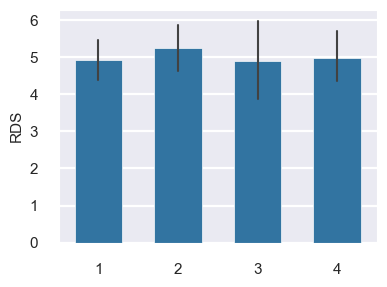

In [196]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(4, 3))  # or adjust figsize as needed
sns.barplot(
    data=df_CA,
    x='type',
    y='RDS',
    #order=sessionID_all_names,
    width=0.6,
    err_kws={'linewidth': 1.5},
    ax=ax
)

#ax.set_ylim(200, 800)
ax.set_xlabel('')
ax.set_ylabel('RDS')

plt.tight_layout()
plt.show()

In [179]:
summary_kdm_acceleration = df_CA.groupby(['type'])['ProspectiveMemory_1'].describe()
print(summary_kdm_acceleration)
pairwise = pg.pairwise_tests(dv='ProspectiveMemory_1', between='type', data=df_CA)
df_t_test = pairwise[['A', 'B', 'T', 'dof', 'p-unc']]
df_t_test.columns = ['A', 'B', 't', 'df', 'p_unc']
df_t_test['t'] = df_t_test['t'].round(3)
df_t_test['p_unc'] = df_t_test['p_unc'].round(3)
df_t_test['df'] = df_t_test['df'].round(0)
print(df_t_test)

      count      mean       std  min  25%  50%   75%  max
type                                                     
1      53.0  1.056604  0.304776  0.0  1.0  1.0  1.00  2.0
2      31.0  1.096774  0.300537  1.0  1.0  1.0  1.00  2.0
3      23.0  1.130435  0.457697  0.0  1.0  1.0  1.00  2.0
4      26.0  1.230769  0.514408  0.0  1.0  1.0  1.75  2.0
   A  B      t    df  p_unc
0  1  2 -0.588  64.0  0.559
1  1  3 -0.708  31.0  0.484
2  1  4 -1.595  34.0  0.120
3  2  3 -0.307  36.0  0.761
4  2  4 -1.171  39.0  0.249
5  3  4 -0.722  47.0  0.474


/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_4428/3274522055.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_kdm_acceleration = df_CA.groupby(['type'])['ProspectiveMemory_1'].describe()
/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_4428/3274522055.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t_test['t'] = df_t_test['t'].round(3)
/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_4428/3274522055.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

In [180]:
summary_kdm_acceleration = df_CA.groupby(['type'])['ProspectiveMemory_2'].describe()
print(summary_kdm_acceleration)
pairwise = pg.pairwise_tests(dv='ProspectiveMemory_2', between='type', data=df_CA)
df_t_test = pairwise[['A', 'B', 'T', 'dof', 'p-unc']]
df_t_test.columns = ['A', 'B', 't', 'df', 'p_unc']
df_t_test['t'] = df_t_test['t'].round(3)
df_t_test['p_unc'] = df_t_test['p_unc'].round(3)
df_t_test['df'] = df_t_test['df'].round(0)
print(df_t_test)

      count      mean       std  min  25%  50%   75%  max
type                                                     
1      23.0  1.086957  0.288104  1.0  1.0  1.0  1.00  2.0
2       8.0  1.250000  0.462910  1.0  1.0  1.0  1.25  2.0
3      14.0  1.000000  0.392232  0.0  1.0  1.0  1.00  2.0
4      14.0  1.142857  0.363137  1.0  1.0  1.0  1.00  2.0
   A  B      t    df  p_unc
0  1  2 -0.935   9.0  0.374
1  1  3  0.720  22.0  0.479
2  1  4 -0.490  23.0  0.629
3  2  3  1.286  13.0  0.221
4  2  4  0.563  12.0  0.584
5  3  4 -1.000  26.0  0.327


/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_4428/548598813.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_kdm_acceleration = df_CA.groupby(['type'])['ProspectiveMemory_2'].describe()
/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_4428/548598813.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t_test['t'] = df_t_test['t'].round(3)
/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_4428/548598813.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

In [181]:
summary_kdm_acceleration = df_CA.groupby(['type'])['ProspectiveMemory_3'].describe()
print(summary_kdm_acceleration)
pairwise = pg.pairwise_tests(dv='ProspectiveMemory_3', between='type', data=df_CA)
df_t_test = pairwise[['A', 'B', 'T', 'dof', 'p-unc']]
df_t_test.columns = ['A', 'B', 't', 'df', 'p_unc']
df_t_test['t'] = df_t_test['t'].round(3)
df_t_test['p_unc'] = df_t_test['p_unc'].round(3)
df_t_test['df'] = df_t_test['df'].round(0)
print(df_t_test)

      count      mean       std  min  25%  50%  75%  max
type                                                    
1     142.0  1.056338  0.390937  0.0  1.0  1.0  1.0  2.0
2      85.0  1.035294  0.325396  0.0  1.0  1.0  1.0  2.0
3      43.0  1.069767  0.402099  0.0  1.0  1.0  1.0  2.0
4      72.0  1.166667  0.444053  0.0  1.0  1.0  1.0  2.0
   A  B      t     df  p_unc
0  1  2  0.437  202.0  0.663
1  1  3 -0.193   68.0  0.847
2  1  4 -1.786  128.0  0.076
3  2  3 -0.487   71.0  0.628
4  2  4 -2.081  128.0  0.039
5  3  4 -1.202   95.0  0.232


/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_4428/2238977355.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_kdm_acceleration = df_CA.groupby(['type'])['ProspectiveMemory_3'].describe()
/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_4428/2238977355.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t_test['t'] = df_t_test['t'].round(3)
/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_4428/2238977355.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

In [182]:
summary_kdm_acceleration = df_CA.groupby(['type'])['ReactionTime_1'].describe()
print(summary_kdm_acceleration)
pairwise = pg.pairwise_tests(dv='ReactionTime_1', between='type', data=df_CA)
df_t_test = pairwise[['A', 'B', 'T', 'dof', 'p-unc']]
df_t_test.columns = ['A', 'B', 't', 'df', 'p_unc']
df_t_test['t'] = df_t_test['t'].round(3)
df_t_test['p_unc'] = df_t_test['p_unc'].round(3)
df_t_test['df'] = df_t_test['df'].round(0)
print(df_t_test)

      count        mean         std    min    25%    50%    75%     max
type                                                                   
1     153.0  534.320261   98.619528  352.0  465.0  512.0  590.0   926.0
2      88.0  547.772727  142.821626  379.0  477.0  527.0  577.5  1633.0
3      47.0  549.723404   91.040531  410.0  501.5  536.0  581.0   977.0
4      79.0  535.759494  102.323546  379.0  456.5  516.0  597.0   953.0
   A  B      t     df  p_unc
0  1  2 -0.783  135.0  0.435
1  1  3 -0.994   82.0  0.323
2  1  4 -0.103  153.0  0.918
3  2  3 -0.097  129.0  0.923
4  2  4  0.629  157.0  0.530
5  3  4  0.795  106.0  0.429


/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_4428/4255460951.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_kdm_acceleration = df_CA.groupby(['type'])['ReactionTime_1'].describe()
/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_4428/4255460951.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t_test['t'] = df_t_test['t'].round(3)
/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_4428/4255460951.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

In [183]:
summary_kdm_acceleration = df_CA.groupby(['type'])['ReactionTime_2'].describe()
print(summary_kdm_acceleration)
pairwise = pg.pairwise_tests(dv='ReactionTime_2', between='type', data=df_CA)
df_t_test = pairwise[['A', 'B', 'T', 'dof', 'p-unc']]
df_t_test.columns = ['A', 'B', 't', 'df', 'p_unc']
df_t_test['t'] = df_t_test['t'].round(3)
df_t_test['p_unc'] = df_t_test['p_unc'].round(3)
df_t_test['df'] = df_t_test['df'].round(0)
print(df_t_test)

      count        mean         std    min     25%    50%     75%    max
type                                                                    
1      23.0  533.217391  100.716956  363.0  482.00  520.0  559.00  809.0
2       8.0  548.125000   50.311707  468.0  522.25  544.5  595.75  606.0
3      14.0  556.857143   87.617049  445.0  499.00  547.0  585.00  777.0
4      14.0  537.500000   85.804563  386.0  490.00  529.0  594.25  679.0
   A  B      t    df  p_unc
0  1  2 -0.542  25.0  0.593
1  1  3 -0.752  31.0  0.458
2  1  4 -0.138  31.0  0.891
3  2  3 -0.297  20.0  0.770
4  2  4  0.366  20.0  0.718
5  3  4  0.591  26.0  0.560


/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_4428/3281874839.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_kdm_acceleration = df_CA.groupby(['type'])['ReactionTime_2'].describe()
/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_4428/3281874839.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t_test['t'] = df_t_test['t'].round(3)
/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_4428/3281874839.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

In [184]:
summary_kdm_acceleration = df_CA.groupby(['type'])['ReactionTime_3'].describe()
print(summary_kdm_acceleration)
pairwise = pg.pairwise_tests(dv='ReactionTime_3', between='type', data=df_CA)
df_t_test = pairwise[['A', 'B', 'T', 'dof', 'p-unc']]
df_t_test.columns = ['A', 'B', 't', 'df', 'p_unc']
df_t_test['t'] = df_t_test['t'].round(3)
df_t_test['p_unc'] = df_t_test['p_unc'].round(3)
df_t_test['df'] = df_t_test['df'].round(0)
print(df_t_test)

      count        mean         std    min     25%    50%     75%     max
type                                                                     
1     142.0  596.260563  100.312821  409.0  522.25  585.0  654.25   915.0
2      85.0  600.035294  125.916020  417.0  522.00  569.0  639.00  1138.0
3      43.0  620.488372  183.254100  348.0  519.00  596.0  672.50  1568.0
4      71.0  596.985915   98.466745  420.0  528.50  585.0  634.00   881.0
   A  B      t     df  p_unc
0  1  2 -0.235  147.0  0.814
1  1  3 -0.830   50.0  0.410
2  1  4 -0.050  142.0  0.960
3  2  3 -0.658   63.0  0.513
4  2  4  0.170  153.0  0.866
5  3  4  0.776   57.0  0.441


/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_4428/1955092090.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_kdm_acceleration = df_CA.groupby(['type'])['ReactionTime_3'].describe()
/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_4428/1955092090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t_test['t'] = df_t_test['t'].round(3)
/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_4428/1955092090.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

In [185]:
summary_kdm_acceleration = df_CA.groupby(['type'])['ReactionTime_4'].describe()
print(summary_kdm_acceleration)
pairwise = pg.pairwise_tests(dv='ReactionTime_4', between='type', data=df_CA)
df_t_test = pairwise[['A', 'B', 'T', 'dof', 'p-unc']]
df_t_test.columns = ['A', 'B', 't', 'df', 'p_unc']
df_t_test['t'] = df_t_test['t'].round(3)
df_t_test['p_unc'] = df_t_test['p_unc'].round(3)
df_t_test['df'] = df_t_test['df'].round(0)
print(df_t_test)

      count        mean         std    min     25%    50%     75%    max
type                                                                    
1      32.0  595.593750  116.391680  441.0  497.25  593.0  641.75  877.0
2       9.0  610.888889   95.456069  452.0  550.00  628.0  695.00  718.0
3       7.0  595.857143   80.040466  492.0  538.50  574.0  663.00  702.0
4      13.0  573.846154   91.127060  445.0  534.00  550.0  594.00  770.0
   A  B      t    df  p_unc
0  1  2 -0.404  15.0  0.692
1  1  3 -0.007  12.0  0.994
2  1  4  0.667  28.0  0.510
3  2  3  0.342  14.0  0.737
4  2  4  0.912  17.0  0.375
5  3  4  0.558  14.0  0.585


/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_4428/1468323940.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_kdm_acceleration = df_CA.groupby(['type'])['ReactionTime_4'].describe()
/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_4428/1468323940.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t_test['t'] = df_t_test['t'].round(3)
/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_4428/1468323940.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

In [186]:
summary_kdm_acceleration = df_CA.groupby(['type'])['TreatmentSeeking'].describe()
print(summary_kdm_acceleration)
pairwise = pg.pairwise_tests(dv='TreatmentSeeking', between='type', data=df_CA)
df_t_test = pairwise[['A', 'B', 'T', 'dof', 'p-unc']]
df_t_test.columns = ['A', 'B', 't', 'df', 'p_unc']
df_t_test['t'] = df_t_test['t'].round(3)
df_t_test['p_unc'] = df_t_test['p_unc'].round(3)
df_t_test['df'] = df_t_test['df'].round(0)
print(df_t_test)

/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_4428/2628051362.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_kdm_acceleration = df_CA.groupby(['type'])['TreatmentSeeking'].describe()


KeyError: 'Column not found: TreatmentSeeking'

In [187]:
summary_kdm_acceleration = df_CA.groupby(['type'])['SymbolDigitSubstitution_1'].describe()
print(summary_kdm_acceleration)
pairwise = pg.pairwise_tests(dv='SymbolDigitSubstitution_1', between='type', data=df_CA)
df_t_test = pairwise[['A', 'B', 'T', 'dof', 'p-unc']]
df_t_test.columns = ['A', 'B', 't', 'df', 'p_unc']
df_t_test['t'] = df_t_test['t'].round(3)
df_t_test['p_unc'] = df_t_test['p_unc'].round(3)
df_t_test['df'] = df_t_test['df'].round(0)
print(df_t_test)

      count       mean       std  min    25%   50%    75%   max
type                                                           
1      89.0  20.393258  5.071350  4.0  18.00  21.0  23.00  31.0
2      61.0  19.377049  5.639633  2.0  16.00  21.0  23.00  31.0
3      34.0  19.529412  6.016318  0.0  17.25  20.0  22.75  31.0
4      48.0  20.666667  5.316907  4.0  18.00  21.0  24.25  31.0
   A  B      t     df  p_unc
0  1  2  1.129  120.0  0.261
1  1  3  0.743   52.0  0.461
2  1  4 -0.292   93.0  0.771
3  2  3 -0.121   65.0  0.904
4  2  4 -1.224  104.0  0.224
5  3  4 -0.884   66.0  0.380


/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_4428/2508486593.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_kdm_acceleration = df_CA.groupby(['type'])['SymbolDigitSubstitution_1'].describe()
/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_4428/2508486593.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t_test['t'] = df_t_test['t'].round(3)
/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_4428/2508486593.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

In [188]:
summary_kdm_acceleration = df_CA.groupby(['type'])['SymbolDigitSubstitution_2'].describe()
print(summary_kdm_acceleration)
pairwise = pg.pairwise_tests(dv='SymbolDigitSubstitution_2', between='type', data=df_CA)
df_t_test = pairwise[['A', 'B', 'T', 'dof', 'p-unc']]
df_t_test.columns = ['A', 'B', 't', 'df', 'p_unc']
df_t_test['t'] = df_t_test['t'].round(3)
df_t_test['p_unc'] = df_t_test['p_unc'].round(3)
df_t_test['df'] = df_t_test['df'].round(0)
print(df_t_test)

      count       mean       std  min    25%   50%    75%   max
type                                                           
1     116.0  19.879310  6.177315  0.0  17.75  21.0  23.25  32.0
2      69.0  18.376812  6.107135  0.0  16.00  19.0  23.00  29.0
3      40.0  17.825000  7.772032  0.0  14.75  19.0  23.00  32.0
4      69.0  19.637681  5.818255  0.0  16.00  20.0  24.00  32.0
   A  B      t     df  p_unc
0  1  2  1.611  144.0  0.109
1  1  3  1.515   57.0  0.135
2  1  4  0.267  150.0  0.790
3  2  3  0.385   67.0  0.701
4  2  4 -1.242  136.0  0.216
5  3  4 -1.282   65.0  0.205


/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_4428/846669564.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_kdm_acceleration = df_CA.groupby(['type'])['SymbolDigitSubstitution_2'].describe()
/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_4428/846669564.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t_test['t'] = df_t_test['t'].round(3)
/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_4428/846669564.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

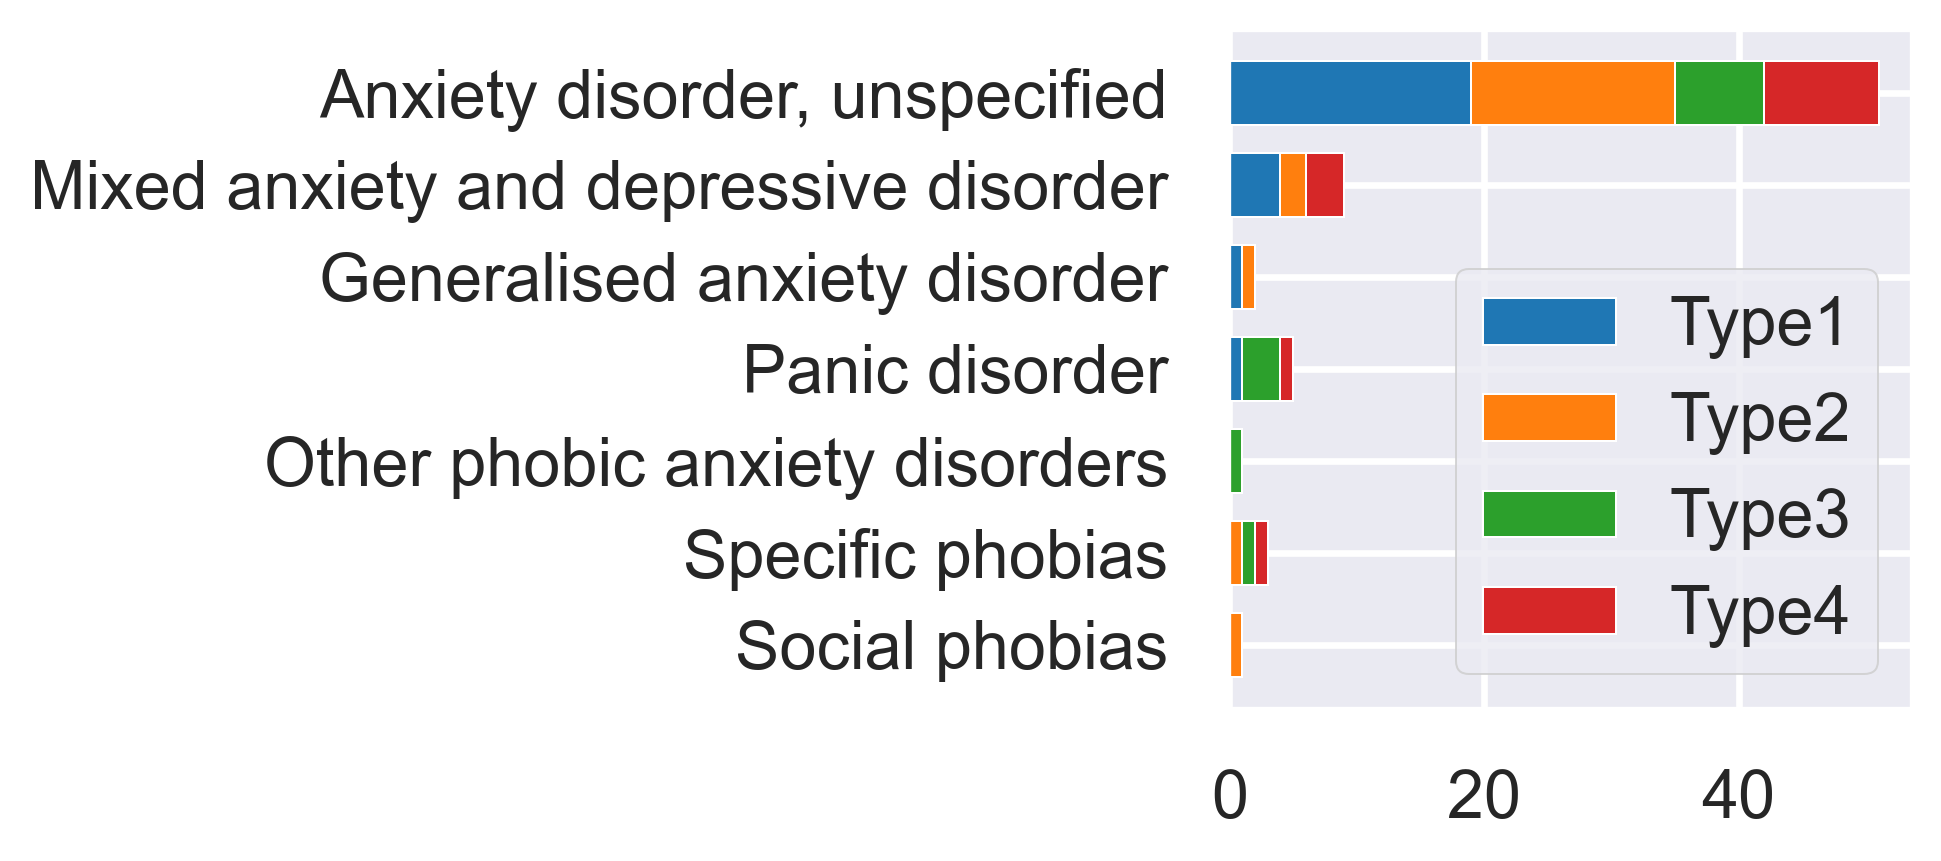

In [13]:
n_in_cluster_df = pd.read_csv('cluster.csv', index_col=0)
df_need = n_in_cluster_df.loc[n_in_cluster_df.index!='No diagnose record']
plt.style.use('seaborn-v0_8-poster')
fontsize = 11
plt.rcParams.update({"font.size": fontsize})
fig, ax = plt.subplots(figsize=(6.6, 3), dpi=300)
bar_width = 0.7  # Adjust as needed
y_positions = np.arange(len(df_need.index))
# Plot bars manually for stacked effect
bottom = np.zeros(len(df_need))  # Initialize bottom position for stacking
colors = plt.cm.tab10.colors  # Use default color palette

for i, col in enumerate(df_need.columns):
    ax.barh(y_positions, df_need[col], height=bar_width, left=bottom, label=col, color=colors[i % len(colors)])
    bottom += df_need[col]  # Update bottom for next stack

# Customize axes
ax.set_yticks(y_positions)
ax.set_yticklabels(df_need.index)
ax.set_xlabel("")
ax.set_ylabel("")
#ax.set_frame_on(False)  # Remove bounding box
ax.legend(loc="best")  # Adjust legend
#plt.yticks(rotation=25)
plt.tight_layout()  # Add padding around plot
# Show the plot
plt.savefig('cluster.png')  # Save figure with 300 DPI
plt.show()

In [14]:
import scipy.stats as stats
chi2_stat, p_value, dof, expected = stats.chi2_contingency(df_need)

# Output results
print(f"Chi-Square Statistic: {chi2_stat}")
print(f"P-value: {p_value}")
print(f"Degrees of Freedom: {dof}")
print(f"Expected Frequencies: \n{expected}")

Chi-Square Statistic: 21.159977591036412
P-value: 0.2714189648487827
Degrees of Freedom: 18
Expected Frequencies: 
[[ 0.34722222  0.29166667  0.16666667  0.19444444]
 [ 1.04166667  0.875       0.5         0.58333333]
 [ 0.34722222  0.29166667  0.16666667  0.19444444]
 [ 1.73611111  1.45833333  0.83333333  0.97222222]
 [ 0.69444444  0.58333333  0.33333333  0.38888889]
 [ 3.125       2.625       1.5         1.75      ]
 [17.70833333 14.875       8.5         9.91666667]]


In [15]:
type1 = [item for item, condition in zip(filtered_list_ah, final_labels) if condition == 1]
type2 = [item for item, condition in zip(filtered_list_ah, final_labels) if condition == 2]
type3 = [item for item, condition in zip(filtered_list_ah, final_labels) if condition == 3]
type4 = [item for item, condition in zip(filtered_list_ah, final_labels) if condition == 4]
controls = list(compress(X_ah, ~y_ah))
X_type1 = type1 + controls
true_values = [True] * len(type1)
false_values = [False] * len(controls)
combined_values = true_values + false_values
y_type1 = pd.Series(combined_values)
X_type1 = np.array(X_type1)

X_type2 = type2 + controls
true_values = [True] * len(type2)
combined_values = true_values + false_values
y_type2 = pd.Series(combined_values)
X_type2 = np.array(X_type2)

X_type3 = type3 + controls
true_values = [True] * len(type3)
combined_values = true_values + false_values
y_type3 = pd.Series(combined_values)
X_type3 = np.array(X_type3)

X_type4 = type4 + controls
true_values = [True] * len(type4)
combined_values = true_values + false_values
y_type4 = pd.Series(combined_values)
X_type4 = np.array(X_type4)

In [16]:
n_features = 10
N_random_state = 422
#9 for ah
final_model_data_set1, final_model_data_set2, final_model_data_set3, final_model_data_set4, selected_features_data_set1, selected_features_data_set2, selected_features_data_set3, selected_features_data_set4, weight_type1, weight_type2, weight_type3, weight_type4 = compare_models_and_analyze_topography1(X_type1, y_type1, X_type2, y_type2, X_type3, y_type3, X_type4, y_type4, n_features, N_random_state)

Training data_set1 model...
Model: Logistic Regression, CV Score: 0.6533
Best Model: Logistic Regression with CV score: 0.6533
Model lacks coefficients/feature importance; using univariate feature selection.
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Best Parameters (Broad Search): {'C': 0.1}
Best Parameters (Narrow Search): {'C': np.float64(0.505)}
Test Set AUC (Final Model): 0.7169
Test Set Accuracy (Final Model): 0.6939
Confusion Matrix:
 [[63  4]
 [26  5]]
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.94      0.81        67
           1       0.56      0.16      0.25        31

    accuracy                           0.69        98
   macro avg       0.63      0.55      0.53        98
weighted avg       0.66      0.69      0.63        98


Training data_set2 model...
Model: Logistic Regression, CV Score: 0.7941
Best Model: Logistic Regression

/Users/xiaoqianxiao/PycharmProjects/UKB_local/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/xiaoqianxiao/PycharmProjects/UKB_local/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/xiaoqianxiao/PycharmProjects/UKB_local/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

Fitting 10 folds for each of 5 candidates, totalling 50 fits
Best Parameters (Broad Search): {'C': 0.01}
Best Parameters (Narrow Search): {'C': np.float64(0.001)}
Test Set AUC (Final Model): 0.7026
Test Set Accuracy (Final Model): 0.8831
Confusion Matrix:
 [[68  0]
 [ 9  0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.88      1.00      0.94        68
           1       0.00      0.00      0.00         9

    accuracy                           0.88        77
   macro avg       0.44      0.50      0.47        77
weighted avg       0.78      0.88      0.83        77


Training data_set4 model...
Model: Logistic Regression, CV Score: 0.8108
Best Model: Logistic Regression with CV score: 0.8108
Model lacks coefficients/feature importance; using univariate feature selection.
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Best Parameters (Broad Search): {'C': 1}
B

/Users/xiaoqianxiao/PycharmProjects/UKB_local/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/xiaoqianxiao/PycharmProjects/UKB_local/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/xiaoqianxiao/PycharmProjects/UKB_local/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

In [27]:
df_selected_features_type1 = df_roi_combinations.iloc[selected_features_data_set1]
df_selected_features_type1.loc[:, 'weight'] = weight_type1
df_selected_features_type1['ROI'] = df_selected_features_type1['ROI1'] + 'T' + df_selected_features_type1['ROI2']
print(df_selected_features_type1)
df_selected_features_type2 = df_roi_combinations.iloc[selected_features_data_set2]
df_selected_features_type2.loc[:, 'weight'] = weight_type2
df_selected_features_type2['ROI'] = df_selected_features_type2['ROI1'] + 'T' + df_selected_features_type2['ROI2']
print(df_selected_features_type2)
df_selected_features_type3 = df_roi_combinations.iloc[selected_features_data_set3]
df_selected_features_type3.loc[:, 'weight'] = weight_type3
df_selected_features_type3['ROI'] = df_selected_features_type3['ROI1'] + 'T' + df_selected_features_type3['ROI2']
print(df_selected_features_type3)
df_selected_features_type4 = df_roi_combinations.iloc[selected_features_data_set4]
df_selected_features_type4.loc[:, 'weight'] = weight_type4
df_selected_features_type4['ROI'] = df_selected_features_type4['ROI1'] + 'T' + df_selected_features_type4['ROI2']
print(df_selected_features_type4)

         ROI1       ROI2    weight                ROI
2    lh_dlPFC    rh_mPFC  0.829762   lh_dlPFCTrh_mPFC
27   rh_dlPFC    lh_mPFC  0.537953   rh_dlPFCTlh_mPFC
28   rh_dlPFC    rh_mPFC  0.397146   rh_dlPFCTrh_mPFC
29   rh_dlPFC     lh_PCC  0.825616    rh_dlPFCTlh_PCC
44   rh_dlPFC    lh_pHIP  0.847729   rh_dlPFCTlh_pHIP
53    lh_mPFC    rh_mPFC  1.060812    lh_mPFCTrh_mPFC
78    rh_mPFC     lh_PCC  0.622685     rh_mPFCTlh_PCC
92    rh_mPFC    lh_aHIP  1.170283    rh_mPFCTlh_aHIP
99    rh_mPFC  lh_THA-DA  0.800141  rh_mPFCTlh_THA-DA
102    lh_PCC     rh_PCC  0.477320      lh_PCCTrh_PCC
         ROI1     ROI2    weight               ROI
43   rh_dlPFC  lh_aHIP -0.005567  rh_dlPFCTlh_aHIP
58    lh_mPFC  rh_aHIP -0.005158   lh_mPFCTrh_aHIP
68    lh_mPFC  lh_aHIP -0.005314   lh_mPFCTlh_aHIP
85    rh_mPFC  rh_mAMY -0.004960   rh_mPFCTrh_mAMY
92    rh_mPFC  lh_aHIP -0.005102   rh_mPFCTlh_aHIP
108    lh_PCC  rh_mAMY -0.004558    lh_PCCTrh_mAMY
115    lh_PCC  lh_aHIP -0.005287    lh_PCCTlh_aHI

/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_22425/1325746606.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected_features_type1.loc[:, 'weight'] = weight_type1
/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_22425/1325746606.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected_features_type1['ROI'] = df_selected_features_type1['ROI1'] + 'T' + df_selected_features_type1['ROI2']
/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_22425/1325746606.py:6: S

In [28]:
import pandas as pd

# Function to align ROIs and generate new DataFrames without modifying the originals
def align_rois_generate_new(df_list):
    aligned_pairs = []  # To store aligned pairs of DataFrames
    
    # Iterate over all pairs of DataFrames
    for i in range(len(df_list)):
        for j in range(i + 1, len(df_list)):
            # Get the two DataFrames
            df1, df2 = df_list[i], df_list[j]
            
            # Combine all unique ROIs from both DataFrames
            all_rois = pd.Index(df1['ROI']).union(df2['ROI'])
            
            # Create new aligned DataFrames
            aligned_df1 = df1.set_index('ROI').reindex(all_rois, fill_value=0).reset_index()
            aligned_df2 = df2.set_index('ROI').reindex(all_rois, fill_value=0).reset_index()
            
            # Append the pair of aligned DataFrames to the list
            aligned_pairs.append((aligned_df1, aligned_df2))
    
    return aligned_pairs


df_list = [df_selected_features_type1, df_selected_features_type2, df_selected_features_type3, df_selected_features_type4]

# Call the function
aligned_pairs = align_rois_generate_new(df_list)

# Print results
list_cosine_similarity = []
from sklearn.metrics.pairwise import cosine_similarity
for idx, (df_a, df_b) in enumerate(aligned_pairs):
    #print(f"Aligned Pair {idx + 1} - DataFrame 1:")
    #print(df_a, "\n")
    #print(f"Aligned Pair {idx + 1} - DataFrame 2:")
    #print(df_b, "\n")
    vector1 = df_a['weight'].values.reshape(1, -1)
    vector2 = df_b['weight'].values.reshape(1, -1)
    s = round(cosine_similarity(vector1, vector2)[0][0],3)
    list_cosine_similarity.append(s)

In [29]:
print(list_cosine_similarity)

[np.float64(-0.146), np.float64(0.0), np.float64(-0.102), np.float64(0.0), np.float64(0.0), np.float64(0.204)]


In [30]:
df_selected_features_type1

,ROI1,ROI2,weight,ROI
2,lh_dlPFC,rh_mPFC,0.829762,lh_dlPFCTrh_mPFC
27,rh_dlPFC,lh_mPFC,0.537953,rh_dlPFCTlh_mPFC
28,rh_dlPFC,rh_mPFC,0.397146,rh_dlPFCTrh_mPFC
29,rh_dlPFC,lh_PCC,0.825616,rh_dlPFCTlh_PCC
44,rh_dlPFC,lh_pHIP,0.847729,rh_dlPFCTlh_pHIP
53,lh_mPFC,rh_mPFC,1.060812,lh_mPFCTrh_mPFC
78,rh_mPFC,lh_PCC,0.622685,rh_mPFCTlh_PCC
92,rh_mPFC,lh_aHIP,1.170283,rh_mPFCTlh_aHIP
99,rh_mPFC,lh_THA-DA,0.800141,rh_mPFCTlh_THA-DA
102,lh_PCC,rh_PCC,0.477320,lh_PCCTrh_PCC


In [31]:
df_selected_features_type2

,ROI1,ROI2,weight,ROI
43,rh_dlPFC,lh_aHIP,-0.005567,rh_dlPFCTlh_aHIP
58,lh_mPFC,rh_aHIP,-0.005158,lh_mPFCTrh_aHIP
68,lh_mPFC,lh_aHIP,-0.005314,lh_mPFCTlh_aHIP
85,rh_mPFC,rh_mAMY,-0.004960,rh_mPFCTrh_mAMY
92,rh_mPFC,lh_aHIP,-0.005102,rh_mPFCTlh_aHIP
108,lh_PCC,rh_mAMY,-0.004558,lh_PCCTrh_mAMY
115,lh_PCC,lh_aHIP,-0.005287,lh_PCCTlh_aHIP
118,lh_PCC,lh_mAMY,-0.005213,lh_PCCTlh_mAMY
137,rh_PCC,lh_aHIP,-0.005161,rh_PCCTlh_aHIP
140,rh_PCC,lh_mAMY,-0.005278,rh_PCCTlh_mAMY


In [32]:
df_selected_features_type3

,ROI1,ROI2,weight,ROI
13,lh_dlPFC,rh_THA-VA,-0.003358,lh_dlPFCTrh_THA-VA
40,rh_dlPFC,rh_THA-DA,-0.003370,rh_dlPFCTrh_THA-DA
64,lh_mPFC,rh_THA-VA,-0.003269,lh_mPFCTrh_THA-VA
89,rh_mPFC,rh_THA-DA,-0.002957,rh_mPFCTrh_THA-DA
134,rh_PCC,rh_THA-DA,-0.003035,rh_PCCTrh_THA-DA
296,rh_THA-VA,lh_THA-VA,-0.003742,rh_THA-VATlh_THA-VA
297,rh_THA-VA,lh_THA-DA,-0.003657,rh_THA-VATlh_THA-DA
308,rh_THA-DA,lh_THA-VA,-0.003338,rh_THA-DATlh_THA-VA
364,lh_THA-DP,lh_THA-VA,-0.002486,lh_THA-DPTlh_THA-VA
372,lh_THA-VA,lh_THA-DA,-0.003830,lh_THA-VATlh_THA-DA


In [33]:
df_selected_features_type4

,ROI1,ROI2,weight,ROI
1,lh_dlPFC,lh_mPFC,-2.027687,lh_dlPFCTlh_mPFC
5,lh_dlPFC,lh_Ins,-1.982354,lh_dlPFCTlh_Ins
27,rh_dlPFC,lh_mPFC,-1.437448,rh_dlPFCTlh_mPFC
28,rh_dlPFC,rh_mPFC,-1.056145,rh_dlPFCTrh_mPFC
54,lh_mPFC,lh_PCC,-0.673887,lh_mPFCTlh_PCC
55,lh_mPFC,rh_PCC,-0.480563,lh_mPFCTrh_PCC
75,lh_mPFC,lh_THA-DA,-0.693179,lh_mPFCTlh_THA-DA
79,rh_mPFC,rh_PCC,-2.152182,rh_mPFCTrh_PCC
89,rh_mPFC,rh_THA-DA,-1.663400,rh_mPFCTrh_THA-DA
297,rh_THA-VA,lh_THA-DA,-1.386150,rh_THA-VATlh_THA-DA


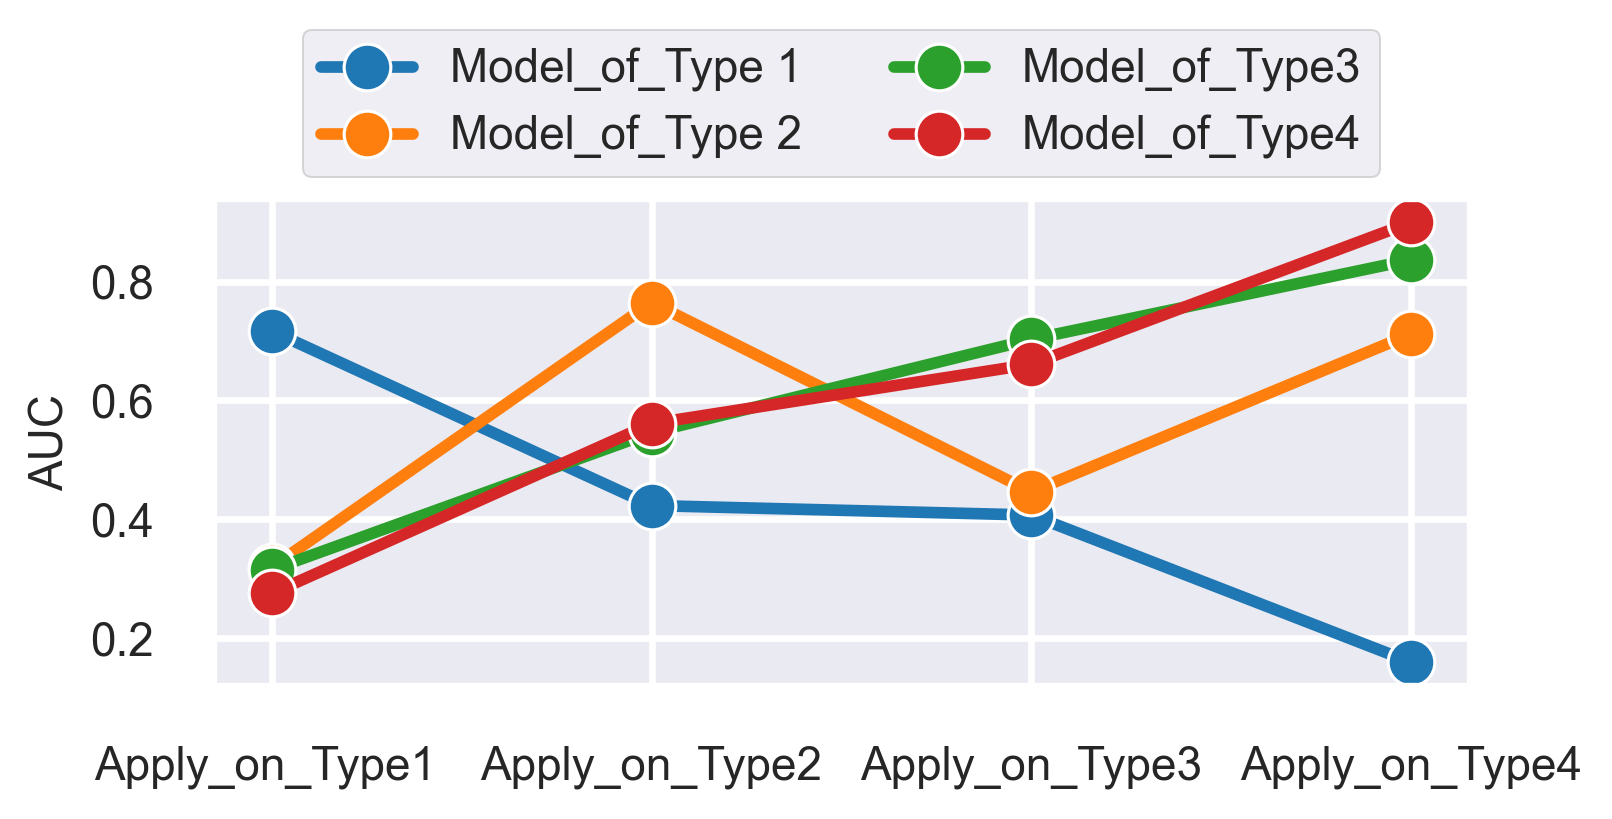

In [34]:
df_results = pd.read_csv('compare_results.csv',index_col=0)
import seaborn as sns
import matplotlib.pyplot as plt

## Transpose the DataFrame for proper line plotting
#df_t = df_results.transpose()
df_t = df_results.copy()
df_t['Apply_to'] = df_t.index  # Add Type as a column for x-axis
df_t.reset_index(drop=True, inplace=True)

# Melt the DataFrame to long-form for Seaborn
df_melted = df_t.melt(id_vars="Apply_to", var_name="Application", value_name="AUC")

# Create the line plot
plt.style.use('seaborn-v0_8-poster')
fontsize = 11
plt.rcParams.update({
    "font.size": fontsize,          # Global font size
    "axes.labelsize": fontsize,     # X and Y axis labels
    "axes.titlesize": fontsize,     # Title (if used)
    "xtick.labelsize": fontsize,    # X-axis tick labels
    "ytick.labelsize": fontsize,    # Y-axis tick labels
    "legend.fontsize": fontsize,    # Legend font size
})
fig, ax = plt.subplots(figsize=(5.5, 3), dpi=300)
sns.lineplot(data=df_melted, x="Apply_to", y="AUC", hue="Application", marker="o", ax=ax)

# Customize the plot
#plt.title("Figure 4. AUC Performance Across Applications")
plt.xlabel("")
plt.ylabel("AUC")

# Customize the legend position
plt.legend(bbox_to_anchor=(0.5, 1.2), loc="center", ncol=2, fontsize=fontsize)
#ax.legend(loc="best")  # Adjust legend
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.savefig('lineplot_model1.png')  # Save figure with 300 DPI
plt.show()

In [35]:
from sklearn.metrics import roc_auc_score
from scipy.stats import norm

def delong_roc_test(y_true, auc1, auc2):
    se = ((auc1 * (1 - auc1)) + (auc2 * (1 - auc2))) / len(y_true)
    z = (auc1 - auc2) / (se ** 0.5)
    p_value = norm.sf(abs(z)) * 2  # Two-tailed test
    return p_value

In [36]:
df_results
true_ys = [y_type1, y_type2, y_type3, y_type4]
types = [1, 2, 3, 4]
print(df_results)

                 Model_of_Type 1  Model_of_Type 2  Model_of_Type3  \
Apply_on_Type1             0.717            0.319           0.315   
Apply_on_Type2             0.423            0.765           0.546   
Apply_on_Type3             0.407            0.446           0.703   
Apply_on_Type4             0.159            0.712           0.837   

                 Model_of_Type4  
Apply_on_Type1            0.275  
Apply_on_Type2            0.561  
Apply_on_Type3            0.661  
Apply_on_Type4            0.900  


In [37]:
# model trained for certain type vs apply that model to another type
p_val = pd.DataFrame(columns=["Model_trained", "Model_apply_to_1", "Model_apply_to_2","pValue"])

for t in range(len(types)):
    true_y = true_ys[t]
    auc1 = df_results.iloc[t, t]    
    for ni in range(len(df_results.index)):
        i = df_results.index[ni]
        ct = df_results.columns[t]
        auc2 = df_results.loc[i, ct]
        row = t*len(types) + ni
        p_val.loc[row, 'pValue'] = round((delong_roc_test(true_y, auc1, auc2) * 16),0) 
        p_val.loc[row, 'Model_trained'] = ct
        p_val.loc[row, 'Model_apply_to_1'] = df_results.index[t]
        p_val.loc[row, 'Model_apply_to_2'] = i
p_val.to_csv('p_val.csv')
print(p_val.shape)

(16, 4)


In [38]:
# model trained for current type vs model train from other type applied on current type
p_val = pd.DataFrame(columns=["Model_apply_to", "Model_trained_1", "Model_trained_2","pValue"])

for t in range(len(types)):
    true_y = true_ys[t]
    auc1 = df_results.iloc[t, t] 
    it = df_results.index[t]
    for nc in range(len(df_results.columns)):
        c = df_results.columns[nc]
        auc2 = df_results.loc[it, c]
        row = t*len(types) + nc
        p_val.loc[row, 'pValue'] = round((delong_roc_test(true_y, auc1, auc2) * 16),0)
        p_val.loc[row, 'Model_apply_to'] = it
        p_val.loc[row, 'Model_trained_1'] = df_results.columns[t]
        p_val.loc[row, 'Model_trained_2'] = c
p_val.to_csv('p_val2.csv')
print(p_val.shape)

(16, 4)


In [39]:
#final_model_data_set1, final_model_data_set2, final_model_data_set3, final_model_data_set4, selected_features_data_set1, selected_features_data_set2, selected_features_data_set3, selected_features_data_set4, weight_type1, weight_type2, weight_type3, weight_type4 = compare_models_and_analyze_topography1(X_type1, y_type1, X_type2, y_type2, X_type3, y_type3, X_type4, y_type4, n_features, N_random_state)
from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_auc_score
perm_importance = permutation_importance(
    final_model_data_set1, X_type1[:, selected_features_data_set1], y_type1, scoring='roc_auc', n_repeats=5000, random_state=422
)
# Create a DataFrame to display permutation importance results
perm_df_type1 = pd.DataFrame({
    "Feature": df_selected_features_type1['ROI'],
    "ROI1": df_selected_features_type1['ROI1'],
    "ROI2": df_selected_features_type1['ROI2'],
    "Importance Mean": perm_importance.importances_mean,
    "Importance Std": perm_importance.importances_std
}).sort_values(by="Importance Mean", ascending=False)

print("\nPermutation Importance (using AUC) for Type1:")
print(perm_df_type1)


Permutation Importance (using AUC) for Type1:
               Feature      ROI1       ROI2  Importance Mean  Importance Std
92     rh_mPFCTlh_aHIP   rh_mPFC    lh_aHIP         0.016463        0.007012
44    rh_dlPFCTlh_pHIP  rh_dlPFC    lh_pHIP         0.010527        0.004889
53     lh_mPFCTrh_mPFC   lh_mPFC    rh_mPFC         0.009887        0.005390
2     lh_dlPFCTrh_mPFC  lh_dlPFC    rh_mPFC         0.009026        0.005739
99   rh_mPFCTlh_THA-DA   rh_mPFC  lh_THA-DA         0.004931        0.004620
102      lh_PCCTrh_PCC    lh_PCC     rh_PCC         0.000892        0.001264
27    rh_dlPFCTlh_mPFC  rh_dlPFC    lh_mPFC         0.000453        0.003499
29     rh_dlPFCTlh_PCC  rh_dlPFC     lh_PCC        -0.000028        0.005011
78      rh_mPFCTlh_PCC   rh_mPFC     lh_PCC        -0.000523        0.003266
28    rh_dlPFCTrh_mPFC  rh_dlPFC    rh_mPFC        -0.000946        0.002073


In [40]:
perm_importance = permutation_importance(
    final_model_data_set2, X_type2[:, selected_features_data_set2], y_type2, scoring='roc_auc', n_repeats=5000, random_state=422
)
# Create a DataFrame to display permutation importance results
perm_df_type2 = pd.DataFrame({
    "Feature": df_selected_features_type2['ROI'],
    "ROI1": df_selected_features_type2['ROI1'],
    "ROI2": df_selected_features_type2['ROI2'],
    "Importance Mean": perm_importance.importances_mean,
    "Importance Std": perm_importance.importances_std
}).sort_values(by="Importance Mean", ascending=False)

print("\nPermutation Importance (using AUC) for Type2:")
print(perm_df_type2)


Permutation Importance (using AUC) for Type2:
              Feature      ROI1     ROI2  Importance Mean  Importance Std
58    lh_mPFCTrh_aHIP   lh_mPFC  rh_aHIP         0.010675        0.005371
85    rh_mPFCTrh_mAMY   rh_mPFC  rh_mAMY         0.009789        0.005442
140    rh_PCCTlh_mAMY    rh_PCC  lh_mAMY         0.009660        0.006209
43   rh_dlPFCTlh_aHIP  rh_dlPFC  lh_aHIP         0.008904        0.007019
118    lh_PCCTlh_mAMY    lh_PCC  lh_mAMY         0.008810        0.006103
115    lh_PCCTlh_aHIP    lh_PCC  lh_aHIP         0.008704        0.005685
108    lh_PCCTrh_mAMY    lh_PCC  rh_mAMY         0.006899        0.004696
137    rh_PCCTlh_aHIP    rh_PCC  lh_aHIP         0.006607        0.005700
68    lh_mPFCTlh_aHIP   lh_mPFC  lh_aHIP         0.003296        0.005878
92    rh_mPFCTlh_aHIP   rh_mPFC  lh_aHIP         0.000972        0.005714


In [41]:
perm_importance = permutation_importance(
    final_model_data_set3, X_type3[:, selected_features_data_set3], y_type3, scoring='roc_auc', n_repeats=5000, random_state=422
)
# Create a DataFrame to display permutation importance results
perm_df_type3 = pd.DataFrame({
    "Feature": df_selected_features_type3['ROI'],
    "ROI1": df_selected_features_type3['ROI1'],
    "ROI2": df_selected_features_type3['ROI2'],
    "Importance Mean": perm_importance.importances_mean,
    "Importance Std": perm_importance.importances_std
}).sort_values(by="Importance Mean", ascending=False)

print("\nPermutation Importance (using AUC) for Type3:")
print(perm_df_type3)


Permutation Importance (using AUC) for Type3:
                 Feature       ROI1       ROI2  Importance Mean  \
372  lh_THA-VATlh_THA-DA  lh_THA-VA  lh_THA-DA         0.007082   
40    rh_dlPFCTrh_THA-DA   rh_dlPFC  rh_THA-DA         0.006673   
296  rh_THA-VATlh_THA-VA  rh_THA-VA  lh_THA-VA         0.004950   
134     rh_PCCTrh_THA-DA     rh_PCC  rh_THA-DA         0.004601   
13    lh_dlPFCTrh_THA-VA   lh_dlPFC  rh_THA-VA         0.003524   
89     rh_mPFCTrh_THA-DA    rh_mPFC  rh_THA-DA         0.001972   
308  rh_THA-DATlh_THA-VA  rh_THA-DA  lh_THA-VA         0.001845   
64     lh_mPFCTrh_THA-VA    lh_mPFC  rh_THA-VA         0.001716   
297  rh_THA-VATlh_THA-DA  rh_THA-VA  lh_THA-DA         0.001288   
364  lh_THA-DPTlh_THA-VA  lh_THA-DP  lh_THA-VA         0.001226   

     Importance Std  
372        0.007987  
40         0.006582  
296        0.008520  
134        0.005312  
13         0.007023  
89         0.005827  
308        0.006781  
64         0.006850  
297        0.0080

In [42]:
perm_importance = permutation_importance(
    final_model_data_set4, X_type4[:, selected_features_data_set4], y_type4, scoring='roc_auc', n_repeats=5000, random_state=422
)
# Create a DataFrame to display permutation importance results
perm_df_type4 = pd.DataFrame({
    "Feature": df_selected_features_type4['ROI'],
    "ROI1": df_selected_features_type4['ROI1'],
    "ROI2": df_selected_features_type4['ROI2'],
    "Importance Mean": perm_importance.importances_mean,
    "Importance Std": perm_importance.importances_std
}).sort_values(by="Importance Mean", ascending=False)

print("\nPermutation Importance (using AUC) for Type4:")
print(perm_df_type4)


Permutation Importance (using AUC) for Type4:
                 Feature       ROI1       ROI2  Importance Mean  \
5        lh_dlPFCTlh_Ins   lh_dlPFC     lh_Ins         0.018707   
1       lh_dlPFCTlh_mPFC   lh_dlPFC    lh_mPFC         0.013286   
79        rh_mPFCTrh_PCC    rh_mPFC     rh_PCC         0.011830   
89     rh_mPFCTrh_THA-DA    rh_mPFC  rh_THA-DA         0.008091   
297  rh_THA-VATlh_THA-DA  rh_THA-VA  lh_THA-DA         0.007679   
27      rh_dlPFCTlh_mPFC   rh_dlPFC    lh_mPFC         0.007208   
28      rh_dlPFCTrh_mPFC   rh_dlPFC    rh_mPFC         0.003488   
75     lh_mPFCTlh_THA-DA    lh_mPFC  lh_THA-DA         0.000623   
54        lh_mPFCTlh_PCC    lh_mPFC     lh_PCC        -0.000268   
55        lh_mPFCTrh_PCC    lh_mPFC     rh_PCC        -0.000977   

     Importance Std  
5          0.008116  
1          0.006063  
79         0.005798  
89         0.005095  
297        0.004667  
27         0.005473  
28         0.003089  
75         0.002095  
54         0.0017

In [991]:
import re
perm_df_type1['bROI1'] = perm_df_type1['ROI1'].apply(lambda x: pd.Series(re.split('_', x))).iloc[:,1]
perm_df_type1['bROI2'] = perm_df_type1['ROI2'].apply(lambda x: pd.Series(re.split('_', x))).iloc[:,1]
df_long_type1 = pd.melt(perm_df_type1, id_vars=["Importance Mean"], value_vars=["bROI1", "bROI2"], var_name="bROI_from", value_name="bROI")
df_importance_type1 = df_long_type1.groupby(['bROI']).agg({'Importance Mean': 'sum'}).reset_index()
df_importance_type1['type'] = 'type1'
print(df_importance_type1.sort_values(by="Importance Mean", ascending=False))
perm_df_type1['bbROI'] = perm_df_type1['bROI1'] + '_' + perm_df_type1['bROI2']
net_df_type1 = perm_df_type1.groupby('bbROI').agg({'Importance Mean': 'sum'}).reset_index()
net_df_type1['type'] = 'type1'
print(net_df_type1.sort_values(by="Importance Mean", ascending=False))

     bROI  Importance Mean   type
4    mPFC         0.049179  type1
3   dlPFC         0.019032  type1
2    aHIP         0.016463  type1
5    pHIP         0.010527  type1
1  THA-DA         0.004931  type1
0     PCC         0.001233  type1
         bbROI  Importance Mean   type
6    mPFC_aHIP         0.016463  type1
3   dlPFC_pHIP         0.010527  type1
7    mPFC_mPFC         0.009887  type1
2   dlPFC_mPFC         0.008533  type1
5  mPFC_THA-DA         0.004931  type1
0      PCC_PCC         0.000892  type1
1    dlPFC_PCC        -0.000028  type1
4     mPFC_PCC        -0.000523  type1


In [992]:
perm_df_type2['bROI1'] = perm_df_type2['ROI1'].apply(lambda x: pd.Series(re.split('_', x))).iloc[:,1]
perm_df_type2['bROI2'] = perm_df_type2['ROI2'].apply(lambda x: pd.Series(re.split('_', x))).iloc[:,1]
df_long_type2 = pd.melt(perm_df_type2, id_vars=["Importance Mean"], value_vars=["bROI1", "bROI2"], var_name="bROI_from", value_name="bROI")
df_importance_type2 = df_long_type2.groupby(['bROI']).agg({'Importance Mean': 'sum'}).reset_index()
df_importance_type2['type'] = 'type2'
print(df_importance_type2.sort_values(by="Importance Mean", ascending=False))
perm_df_type2['bbROI'] = perm_df_type2['bROI1'] + '_' + perm_df_type2['bROI2']
net_df_type2 = perm_df_type2.groupby('bbROI').agg({'Importance Mean': 'sum'}).reset_index()
net_df_type2['type'] = 'type2'
print(net_df_type2.sort_values(by="Importance Mean", ascending=False))

    bROI  Importance Mean   type
0    PCC         0.040680  type2
1   aHIP         0.039158  type2
3   mAMY         0.035159  type2
4   mPFC         0.024732  type2
2  dlPFC         0.008904  type2
        bbROI  Importance Mean   type
1    PCC_mAMY         0.025370  type2
0    PCC_aHIP         0.015310  type2
3   mPFC_aHIP         0.014943  type2
4   mPFC_mAMY         0.009789  type2
2  dlPFC_aHIP         0.008904  type2


In [993]:
perm_df_type3['bROI1'] = perm_df_type3['ROI1'].apply(lambda x: pd.Series(re.split('_', x))).iloc[:,1]
perm_df_type3['bROI2'] = perm_df_type3['ROI2'].apply(lambda x: pd.Series(re.split('_', x))).iloc[:,1]
df_long_type3 = pd.melt(perm_df_type3, id_vars=["Importance Mean"], value_vars=["bROI1", "bROI2"], var_name="bROI_from", value_name="bROI")
df_importance_type3 = df_long_type3.groupby(['bROI']).agg({'Importance Mean': 'sum'}).reset_index()
df_importance_type3['type'] = 'type3'
print(df_importance_type3.sort_values(by="Importance Mean", ascending=False))
perm_df_type3['bbROI'] = perm_df_type3['bROI1'] + '_' + perm_df_type3['bROI2']
net_df_type3 = perm_df_type3.groupby('bbROI').agg({'Importance Mean': 'sum'}).reset_index()
net_df_type3['type'] = 'type3'
print(net_df_type3.sort_values(by="Importance Mean", ascending=False))

     bROI  Importance Mean   type
3  THA-VA         0.026581  type3
1  THA-DA         0.023461  type3
4   dlPFC         0.010197  type3
0     PCC         0.004601  type3
5    mPFC         0.003688  type3
2  THA-DP         0.001226  type3
           bbROI  Importance Mean   type
3  THA-VA_THA-DA         0.008371  type3
5   dlPFC_THA-DA         0.006673  type3
4  THA-VA_THA-VA         0.004950  type3
0     PCC_THA-DA         0.004601  type3
6   dlPFC_THA-VA         0.003524  type3
7    mPFC_THA-DA         0.001972  type3
1  THA-DA_THA-VA         0.001845  type3
8    mPFC_THA-VA         0.001716  type3
2  THA-DP_THA-VA         0.001226  type3


In [994]:
perm_df_type4['bROI1'] = perm_df_type4['ROI1'].apply(lambda x: pd.Series(re.split('_', x))).iloc[:,1]
perm_df_type4['bROI2'] = perm_df_type4['ROI2'].apply(lambda x: pd.Series(re.split('_', x))).iloc[:,1]
df_long_type4 = pd.melt(perm_df_type4, id_vars=["Importance Mean"], value_vars=["bROI1", "bROI2"], var_name="bROI_from", value_name="bROI")
df_importance_type4 = df_long_type4.groupby(['bROI']).agg({'Importance Mean': 'sum'}).reset_index()
df_importance_type4['type'] = 'type4'
print(df_importance_type4.sort_values(by="Importance Mean", ascending=False))
perm_df_type4['bbROI'] = perm_df_type4['bROI1'] + '_' + perm_df_type4['bROI2']
net_df_type4 = perm_df_type4.groupby('bbROI').agg({'Importance Mean': 'sum'}).reset_index()
net_df_type4['type'] = 'type4'
print(net_df_type4.sort_values(by="Importance Mean", ascending=False))

     bROI  Importance Mean   type
5    mPFC         0.043283  type4
4   dlPFC         0.042690  type4
0     Ins         0.018707  type4
2  THA-DA         0.016393  type4
1     PCC         0.010586  type4
3  THA-VA         0.007679  type4
           bbROI  Importance Mean   type
2     dlPFC_mPFC         0.023983  type4
1      dlPFC_Ins         0.018707  type4
3       mPFC_PCC         0.010586  type4
4    mPFC_THA-DA         0.008714  type4
0  THA-VA_THA-DA         0.007679  type4


In [985]:
df_importance = pd.concat([df_importance_type1, df_importance_type2, df_importance_type3, df_importance_type4], axis=0)
print(df_importance)

     bROI  Importance Mean   type
0     PCC         0.001233  type1
1  THA-DA         0.004931  type1
2    aHIP         0.016463  type1
3   dlPFC         0.019032  type1
4    mPFC         0.049179  type1
5    pHIP         0.010527  type1
0     PCC         0.040680  type2
1    aHIP         0.039158  type2
2   dlPFC         0.008904  type2
3    mAMY         0.035159  type2
4    mPFC         0.024732  type2
0     PCC         0.004601  type3
1  THA-DA         0.023461  type3
2  THA-DP         0.001226  type3
3  THA-VA         0.026581  type3
4   dlPFC         0.010197  type3
5    mPFC         0.003688  type3
0     Ins         0.018707  type4
1     PCC         0.010586  type4
2  THA-DA         0.016393  type4
3  THA-VA         0.007679  type4
4   dlPFC         0.042690  type4
5    mPFC         0.043283  type4


In [986]:
import plotly.graph_objects as go
import pandas as pd
import plotly.express as px

# Assuming df_importance is already loaded

# Explicitly order the types
types_ordered = ["type1", "type2", "type3", "type4"]  # Enforce desired type order
brois_ordered = df_importance['bROI'].unique().tolist()  # Keep bROIs in natural order
labels_ordered = types_ordered + brois_ordered  # Combined label list

# Map source and target indices based on ordered labels
df_importance['source'] = df_importance['type'].apply(lambda x: types_ordered.index(x))
df_importance['target'] = df_importance['bROI'].apply(lambda x: len(types_ordered) + brois_ordered.index(x))

# Define y positions to control vertical placement (types at y=1, bROIs at y=0)
type_y_positions = [1] * len(types_ordered)  # High y for types
broi_y_positions = [0] * len(brois_ordered)  # Low y for bROIs
node_y_positions = type_y_positions + broi_y_positions  # Combine

# Define x positions to control horizontal placement (types at x=0, bROIs at x=1)
node_x_positions = [0] * len(types_ordered) + [1] * len(brois_ordered)

# Define link colors based on type
link_colors = df_importance['type'].map({
    "type1": "blue",
    "type2": "orange",
    "type3": "green",
    "type4": "red"
})

# Use a different color palette (Viridis) for the target (bROI) nodes
target_colors = px.colors.qualitative.Dark24
# Ensure that the number of colors matches the number of bROIs
target_colors = target_colors[:len(brois_ordered)]

# Create Sankey diagram
fig = go.Figure(go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels_ordered,
        color=["blue", "orange", "green", "red"] + target_colors,  # Color for types and unique bROIs
        x=node_x_positions,  # Control x position
        y=node_y_positions,  # Control y position for vertical placement
    ),
    link=dict(
        source=df_importance['source'],
        target=df_importance['target'],
        value=df_importance['Importance Mean'],
        color=link_colors.tolist(),  # Link colors based on source (type)
    )
))

# Update layout to control node arrangement and figure size
fig.update_layout(
    #title_text="Sankey Diagram",
    font_size=fontsize,
    xaxis=dict(showgrid=False, zeroline=False),  # Hide gridlines for x-axis
    yaxis=dict(showgrid=False, zeroline=False),  # Hide gridlines for y-axis
    width=600,  # 12 inches in pixels (at 100 DPI)
    height=600,  # 6 inches in pixels (at 100 DPI)
)
#fig.write_image("sankey_diagram_with_target_colors.png", scale=3) 
# Show the figure (no saving)
fig.show()


In [990]:
#circular plot
df_importance_net = pd.concat([net_df_type1, net_df_type2, net_df_type3, net_df_type4], axis=0)
df_importance_net['ROI1'] = df_importance_net['bbROI'].apply(lambda x: pd.Series(re.split('_', x))).iloc[:,0]
df_importance_net['ROI2'] = df_importance_net['bbROI'].apply(lambda x: pd.Series(re.split('_', x))).iloc[:,1]
print(df_importance_net)

           bbROI  Importance Mean   type    ROI1    ROI2
1       PCC_mAMY         0.025370  type2     PCC    mAMY
2     dlPFC_mPFC         0.023983  type4   dlPFC    mPFC
1      dlPFC_Ins         0.018707  type4   dlPFC     Ins
6      mPFC_aHIP         0.016463  type1    mPFC    aHIP
0       PCC_aHIP         0.015310  type2     PCC    aHIP
3      mPFC_aHIP         0.014943  type2    mPFC    aHIP
3       mPFC_PCC         0.010586  type4    mPFC     PCC
3     dlPFC_pHIP         0.010527  type1   dlPFC    pHIP
7      mPFC_mPFC         0.009887  type1    mPFC    mPFC
4      mPFC_mAMY         0.009789  type2    mPFC    mAMY
2     dlPFC_aHIP         0.008904  type2   dlPFC    aHIP
4    mPFC_THA-DA         0.008714  type4    mPFC  THA-DA
2     dlPFC_mPFC         0.008533  type1   dlPFC    mPFC
3  THA-VA_THA-DA         0.008371  type3  THA-VA  THA-DA
0  THA-VA_THA-DA         0.007679  type4  THA-VA  THA-DA
5   dlPFC_THA-DA         0.006673  type3   dlPFC  THA-DA
4  THA-VA_THA-VA         0.0049

In [988]:
df_importance_net_positive = df_importance_net.loc[df_importance_net['Importance Mean'] > 0]
df_importance_net_positive['Importance'] = df_importance_net_positive['Importance Mean'] * 100

/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_59761/4266631228.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [1077]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np

# Define color map for the types
type_colors = {
    'type1': 'blue',
    'type2': 'orange',
    'type3': 'green',
    'type4': 'red'
}
line_styles = {
    'type1': 'solid',  # Solid line for type1
    'type2': 'dash',   # Dashed line for type2
    'type3': 'dot',    # Dotted line for type3
    'type4': 'dashdot' # Dash-dot line for type4
}
# Create the node labels (use ROI1 and ROI2)
unique_rois = pd.concat([df_importance_net_positive['ROI1'], df_importance_net_positive['ROI2']]).unique().tolist()

# Create node positions in a circular layout (with increased radius for clarity)
theta = [i * 2 * np.pi / len(unique_rois) for i in range(len(unique_rois))]
radius = 1.2  # Increase the radius for better spacing
x_positions = [radius * np.cos(t) for t in theta]
y_positions = [radius * np.sin(t) for t in theta]

# Create node positions in a circular layout (with increased radius for clarity)
theta = [i * 2 * np.pi / len(unique_rois) for i in range(len(unique_rois))]
radius = 1.2  # Increase the radius for better spacing
x_positions = [radius * np.cos(t) for t in theta]
y_positions = [radius * np.sin(t) for t in theta]

# Adjust label positions to avoid overlap, with specific adjustments for the first 4 nodes
x_offset = 0.1  # Small offset to the right

# Adjust y_offset for different labels
y_positions_label = []
for i, y in enumerate(y_positions):
    if i < 3:  # First three nodes: move right
        y_positions_label.append(y + 0.1)  # Keep the y positions as they are
        x_positions[i] += 0.25  # Move the first three nodes to the right
    elif i == 3:  # Fourth node: move up
        y_positions_label.append(y + 0.1)  # Move the fourth node upwards
    elif i==7 or i == 8: 
        y_positions_label.append(y - 0.2)
    else:  # For the rest of the nodes, maintain the original offsets
        y_positions_label.append(y)

x_positions_label = [x + x_offset for x in x_positions]
x_positions_label[5] = x_positions_label[5] - 0.4
x_positions_label[6] = x_positions_label[6] - 0.2
x_positions_label[4] = x_positions_label[4] - 0.1

#for i in [5,6]:
#    x_positions_label[i] = x_positions_label[i] - 0.2

# Create source and target mappings based on ROI1 and ROI2 names
source_idx = df_importance_net_positive['ROI1'].apply(lambda x: unique_rois.index(x)).tolist()
target_idx = df_importance_net_positive['ROI2'].apply(lambda x: unique_rois.index(x)).tolist()

# Define link colors based on the type column
link_colors = df_importance_net_positive['type'].map(type_colors).tolist()
link_line_styles = df_importance_net_positive['type'].map(line_styles).tolist()

# Use Dark24 color palette for the nodes
node_colors = px.colors.qualitative.Dark24[:len(unique_rois)]

# Define font size for the labels
fontsize = 20  # You can adjust the font size here

# Create the circular plot using Plotly
fig = go.Figure()

# Add the nodes (with positions and labels)
fig.add_trace(go.Scatter(
    x=x_positions,  # Position on the x-axis for nodes
    y=y_positions,  # Position on the y-axis for nodes
    mode='markers',
    textfont=dict(size=fontsize),  # Set font size for node labels
    marker=dict(
        size=18,
        color=node_colors  # Node color (same for all)
        #line=dict(color='black', width=2)
    ),
    showlegend=False
))

# Add the links between source and target ROIs
for i in range(len(df_importance_net_positive)):
    fig.add_trace(go.Scatter(
        x=[x_positions[source_idx[i]], x_positions[target_idx[i]]],
        y=[y_positions[source_idx[i]], y_positions[target_idx[i]]],
        mode='lines+text',
        line=dict(color=link_colors[i], width=abs(df_importance_net_positive['Importance'].iloc[i]) * 5, dash=link_line_styles[i]),
        opacity=0.4,  # Scale link width by Importance Mean and ensure it's positive
        showlegend=False
    ))
# Add labels at the adjusted positions
fig.add_trace(go.Scatter(
    x=x_positions_label,  # Position on the x-axis for node labels
    y=y_positions_label,  # Position on the y-axis for node labels
    mode='text',
    text=unique_rois,
    textposition='top center',  # Positioning the text labels at the top center
    textfont=dict(size=fontsize),  # Set font size for node labels
    showlegend=False
))
# Add custom legend for link types with different line styles
fig.add_trace(go.Scatter(
    x=[None], y=[None],  # Invisible plot for legend entry
    mode='lines',
    line=dict(color='blue', width=3, dash='solid'),
    name='type1 (solid)'
))
fig.add_trace(go.Scatter(
    x=[None], y=[None],  # Invisible plot for legend entry
    mode='lines',
    line=dict(color='orange', width=3, dash='dash'),
    name='type2 (dashed)'
))
fig.add_trace(go.Scatter(
    x=[None], y=[None],  # Invisible plot for legend entry
    mode='lines',
    line=dict(color='green', width=3, dash='dot'),
    name='type3 (dotted)'
))
fig.add_trace(go.Scatter(
    x=[None], y=[None],  # Invisible plot for legend entry
    mode='lines',
    line=dict(color='red', width=3, dash='dashdot'),
    name='type4 (dash-dot)'
))

# Update layout for better visuals
fig.update_layout(
    #title="Circular Plot of Connections Between ROIs",
    font=dict(size=fontsize),  # Set font size for labels
    plot_bgcolor='white',
    width=580, 
    height=550,
    showlegend=True,
    legend=dict(
        orientation='h',  # Horizontal legend
        yanchor='bottom',  # Position at the bottom
        y=-0.1,  # Slightly below the plot
        x=0.5,  # Centered horizontally
        xanchor='center'
    ),
    xaxis=dict(showticklabels=False, zeroline=False),  # Hide x-axis labels and grid
    yaxis=dict(showticklabels=False, zeroline=False),  # Hide y-axis labels and grid
    margin=dict(t=50, b=50, l=50, r=50)  # Adjust margin to make the plot more centered
)

# Show the plot
fig.show()


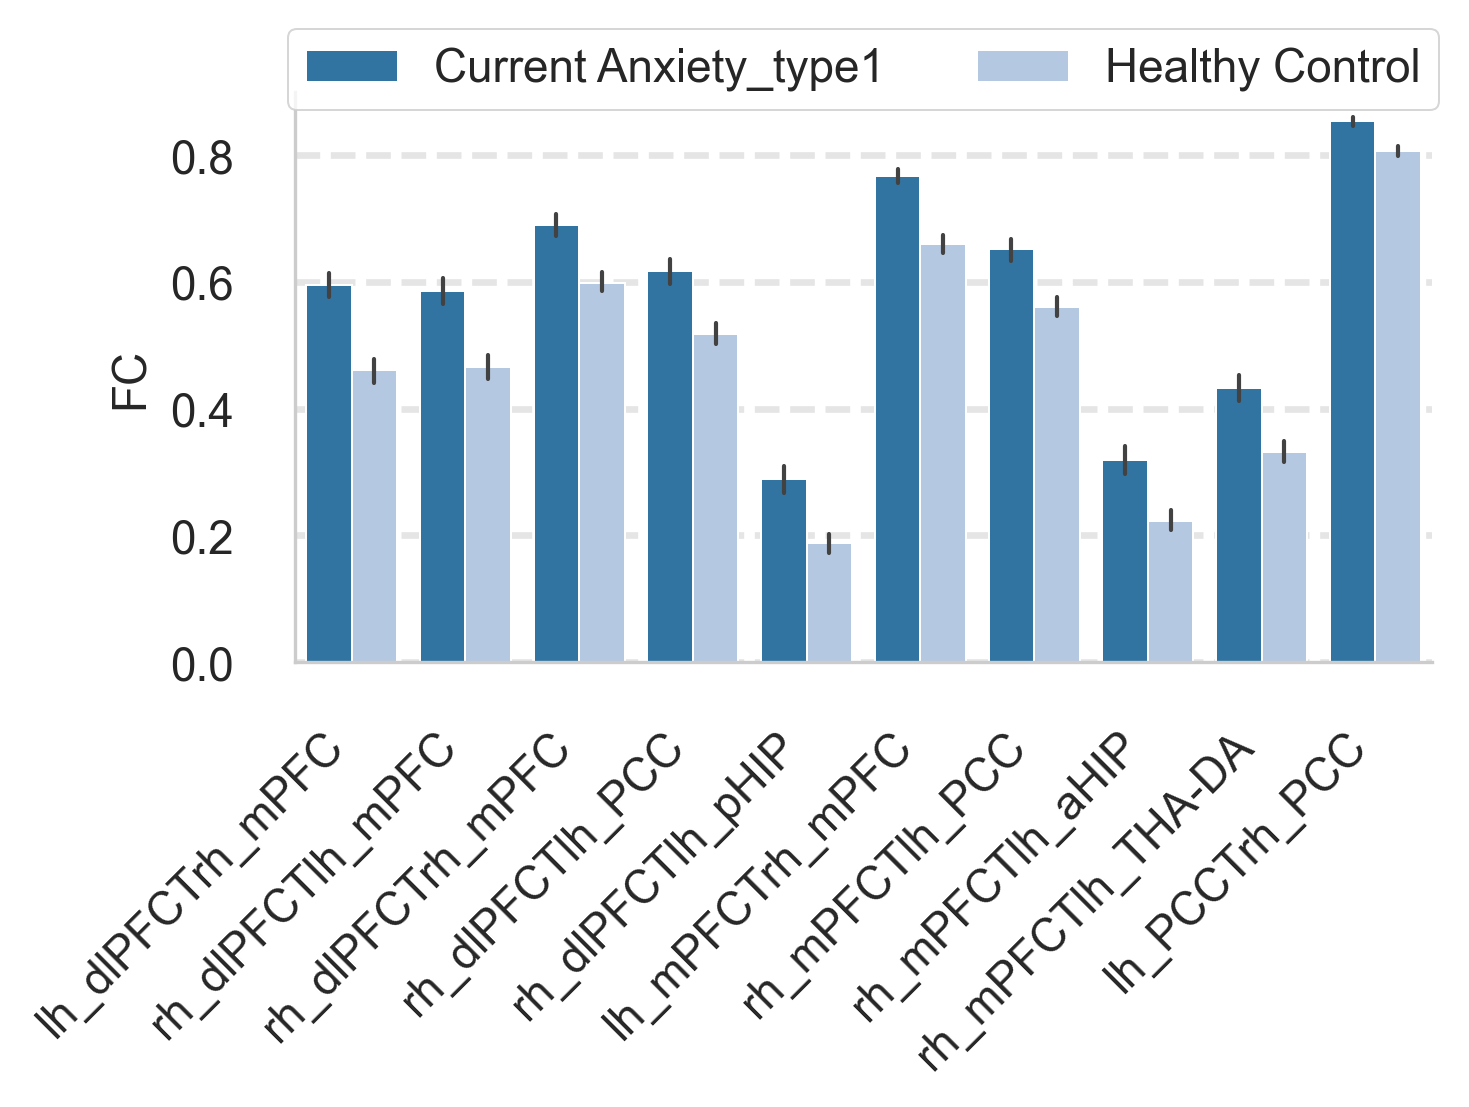

In [1196]:
df_bs_type1 = pd.DataFrame(X_type1[:, selected_features_data_set1])
df_bs_type1.columns = list(df_selected_features_type1['ROI'])
df_bs_type1['Anxiety'] = y_type1
# Relabel the 'Anxiety' column
df_bs_type1['Anxiety'] = df_bs_type1['Anxiety'].map({False: 'Healthy Control', True: 'Current Anxiety_type1'})

# Melt the dataframe to long format for seaborn compatibility
df_long = df_bs_type1.melt(id_vars=['Anxiety'], value_vars=df_bs_type1.columns[:-1],
                           var_name='Region', value_name='FC')

# Create a bar plot
plt.style.use('seaborn-v0_8-poster')
fontsize = 11
plt.rcParams.update({
    "font.size": fontsize,          # Global font size
    "axes.labelsize": fontsize,     # X and Y axis labels
    "axes.titlesize": fontsize,     # Title (if used)
    "xtick.labelsize": fontsize,    # X-axis tick labels
    "ytick.labelsize": fontsize,    # Y-axis tick labels
    "legend.fontsize": fontsize,    # Legend font size
})
# Create figure and axis
fig, ax = plt.subplots(figsize=(5, 4), dpi=300)


# Create bar plot with thinner error bars
sns.barplot(
    x="Region", 
    y="FC", 
    hue="Anxiety", 
    data=df_long, 
    err_kws={"linewidth": 1},  # Thinner error bars
    palette=["#1f77b4", "#aec7e8"],  # Consistent blue/light blue color scheme
    ax=ax
)

# Fix x-tick positions and labels
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")  
# Customize plot
legend = plt.legend(title=None, loc="upper center", bbox_to_anchor=(0.5, 1.15), ncol=2)
plt.grid(axis="y", linestyle="--", alpha=0.5)  # Keep only y-grid for clarity

sns.despine()
plt.ylim(0, 0.9)

plt.tight_layout()

# Save and display the plot
#plt.savefig("bar_model1.png")
plt.show()



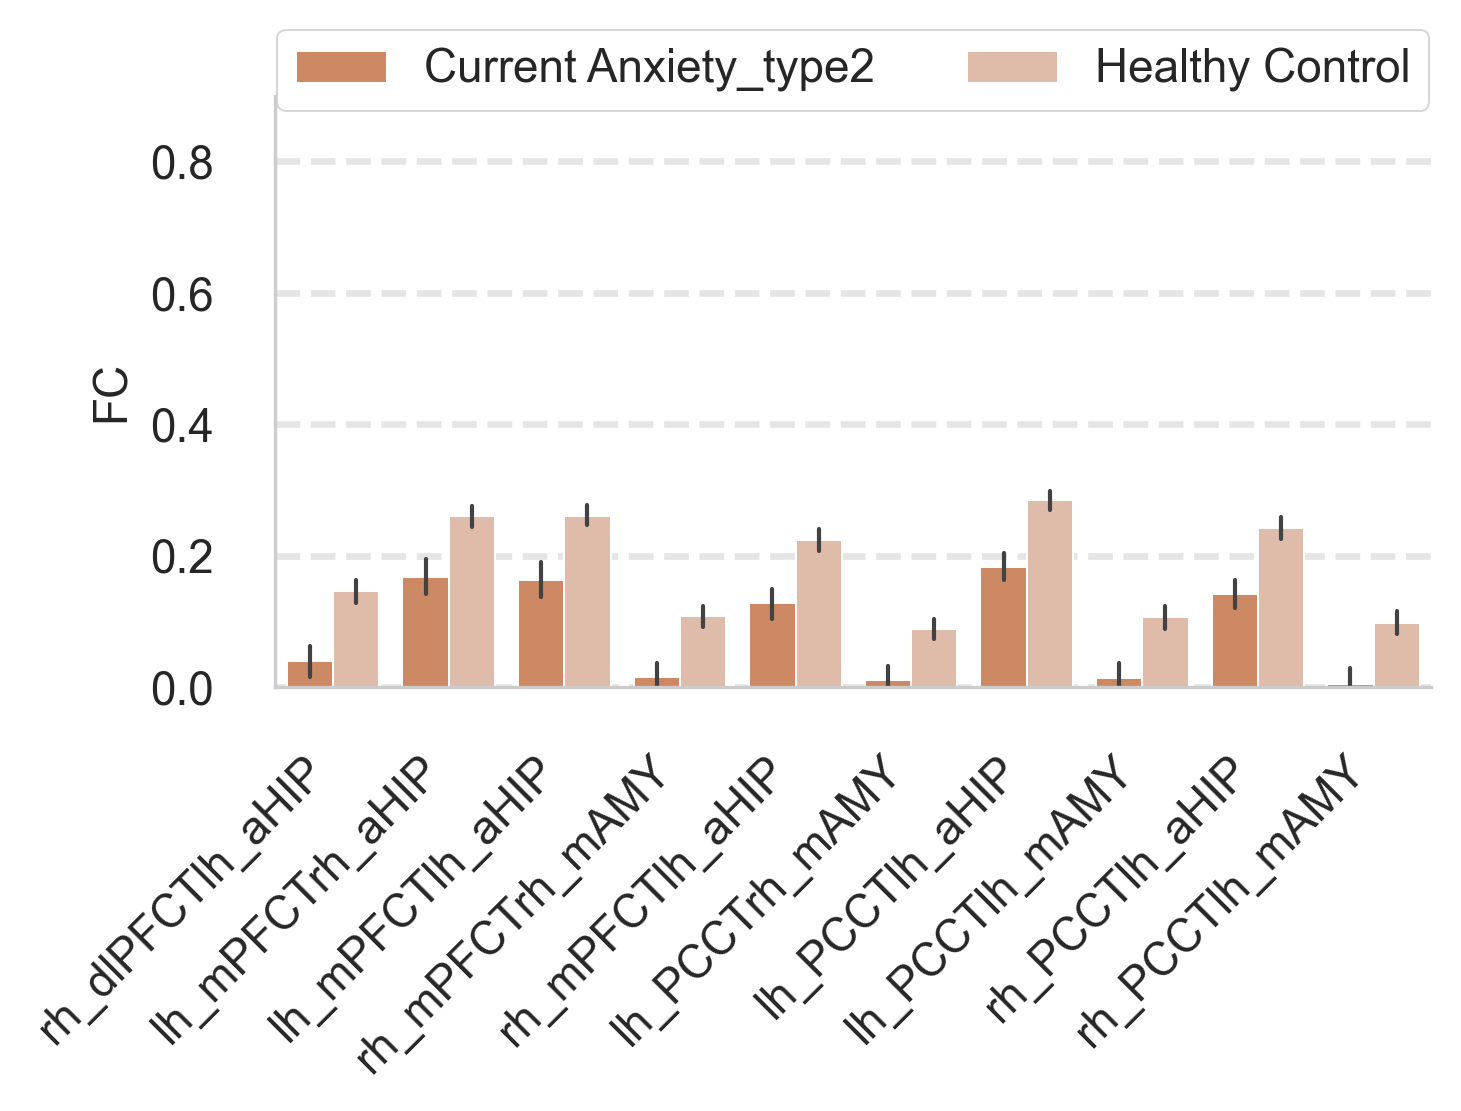

In [1198]:
df_bs_type2 = pd.DataFrame(X_type2[:, selected_features_data_set2])
df_bs_type2.columns = list(df_selected_features_type2['ROI'])
df_bs_type2['Anxiety'] = y_type2
# Relabel the 'Anxiety' column
df_bs_type2['Anxiety'] = df_bs_type2['Anxiety'].map({False: 'Healthy Control', True: 'Current Anxiety_type2'})

# Melt the dataframe to long format for seaborn compatibility
df_long = df_bs_type2.melt(id_vars=['Anxiety'], value_vars=df_bs_type2.columns[:-1],
                           var_name='Region', value_name='FC')

# Create a bar plot
plt.style.use('seaborn-v0_8-poster')
fontsize = 11
plt.rcParams.update({
   "font.size": fontsize,          # Global font size
    "axes.labelsize": fontsize,     # X and Y axis labels
    "axes.titlesize": fontsize,     # Title (if used)
    "xtick.labelsize": fontsize,    # X-axis tick labels
    "ytick.labelsize": fontsize,    # Y-axis tick labels
    "legend.fontsize": fontsize,    # Legend font size
})
# # Create figure and axis
fig, ax = plt.subplots(figsize=(5, 4), dpi=300)
default_orange = sns.color_palette("deep")[1]  # Orange (#ff7f0e)
lighter_orange = sns.light_palette(default_orange, n_colors=3)[1]  # Light orange
# Create bar plot with thinner error bars
sns.barplot(
    x="Region", 
    y="FC", 
    hue="Anxiety", 
    data=df_long, 
    err_kws={"linewidth": 1},  # Thinner error bars
    palette=[default_orange, lighter_orange],  # Consistent blue/light blue color scheme
    ax=ax
)
# Fix x-tick positions and labels
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")  
# Customize plot
legend = plt.legend(title=None, loc="upper center", bbox_to_anchor=(0.5, 1.15), ncol=2)
plt.grid(axis="y", linestyle="--", alpha=0.5)  # Keep only y-grid for clarity
plt.xlabel("")
sns.despine()
plt.ylim(0, 0.9)

plt.tight_layout()

# Save and display the plot
#plt.savefig("bar_model2.png")
plt.show()


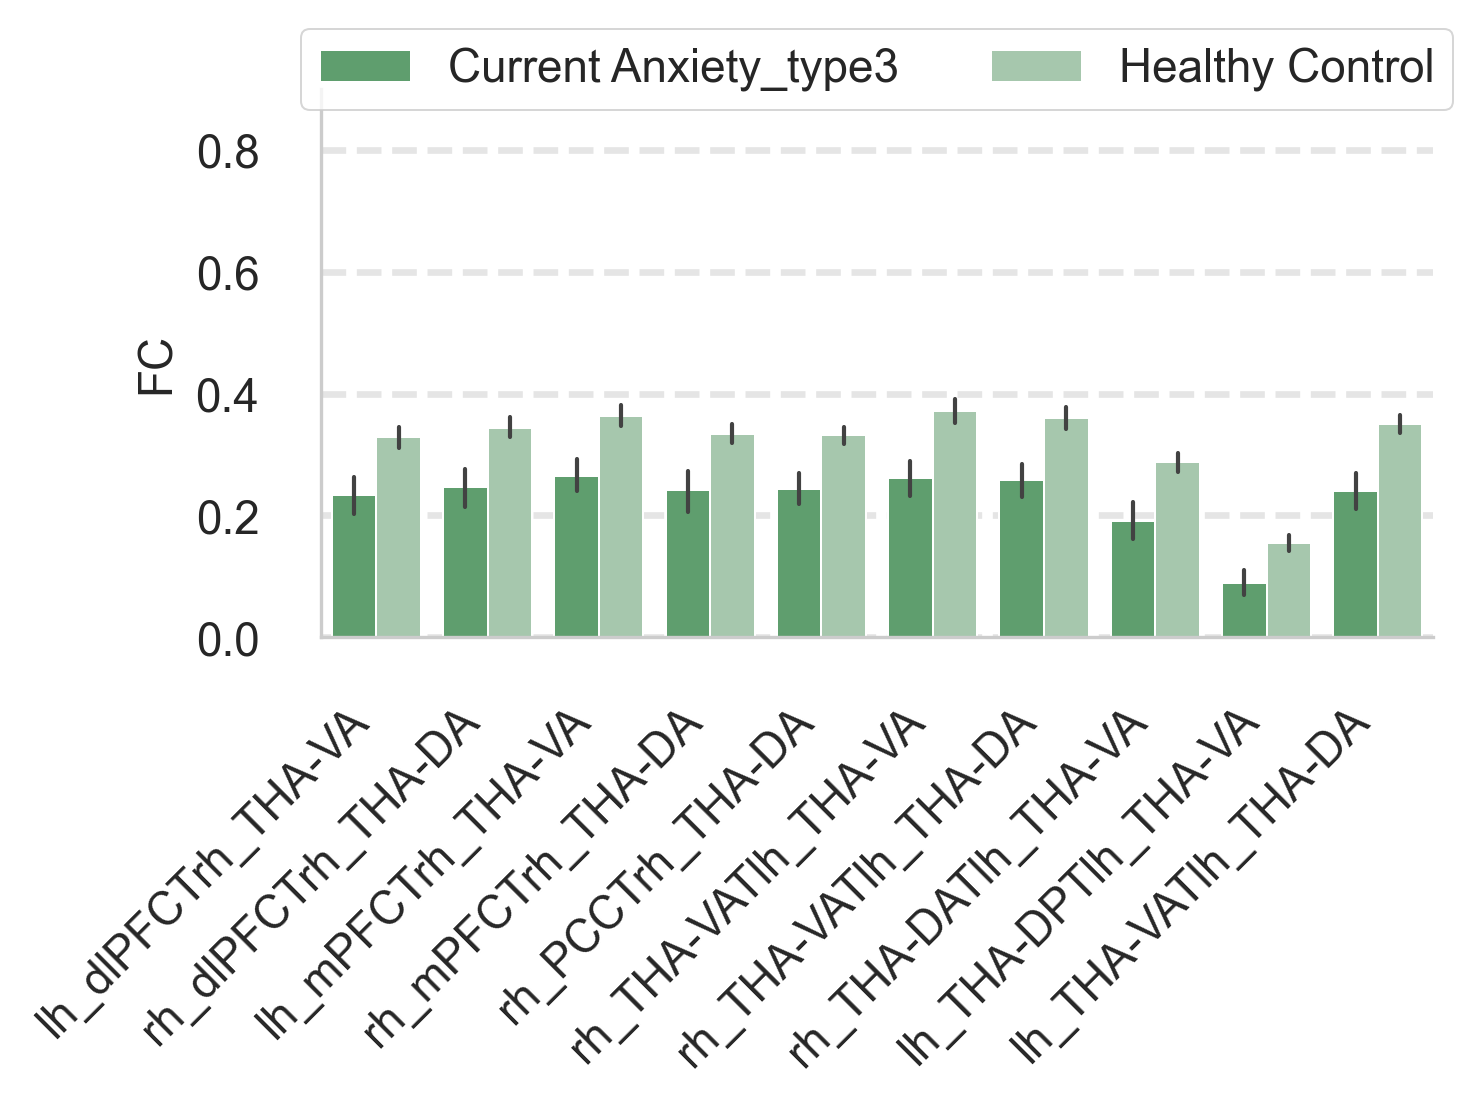

In [1199]:
df_bs_type3 = pd.DataFrame(X_type3[:, selected_features_data_set3])
df_bs_type3.columns = list(df_selected_features_type3['ROI'])
df_bs_type3['Anxiety'] = y_type3
# Relabel the 'Anxiety' column
df_bs_type3['Anxiety'] = df_bs_type3['Anxiety'].map({False: 'Healthy Control', True: 'Current Anxiety_type3'})

# Melt the dataframe to long format for seaborn compatibility
df_long = df_bs_type3.melt(id_vars=['Anxiety'], value_vars=df_bs_type3.columns[:-1],
                           var_name='Region', value_name='FC')

# Create a bar plot
fig, ax = plt.subplots(figsize=(5, 4), dpi=300)
default_green = sns.color_palette("deep")[2]  # Green (#2ca02c)
lighter_green = sns.light_palette(default_green, n_colors=3)[1]  # Light green
# Create bar plot with thinner error bars
sns.barplot(
    x="Region", 
    y="FC", 
    hue="Anxiety", 
    data=df_long, 
    err_kws={"linewidth": 1},  # Thinner error bars
    palette=[default_green, lighter_green],  # Consistent blue/light blue color scheme
    ax=ax
)
# Fix x-tick positions and labels
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")  
# Customize plot
legend = plt.legend(title=None, loc="upper center", bbox_to_anchor=(0.5, 1.15), ncol=2)
plt.grid(axis="y", linestyle="--", alpha=0.5)  # Keep only y-grid for clarity
plt.xlabel("")
sns.despine()
plt.ylim(0, 0.9)

plt.tight_layout()

# Save and display the plot
#plt.savefig("bar_model3.png")
plt.show()


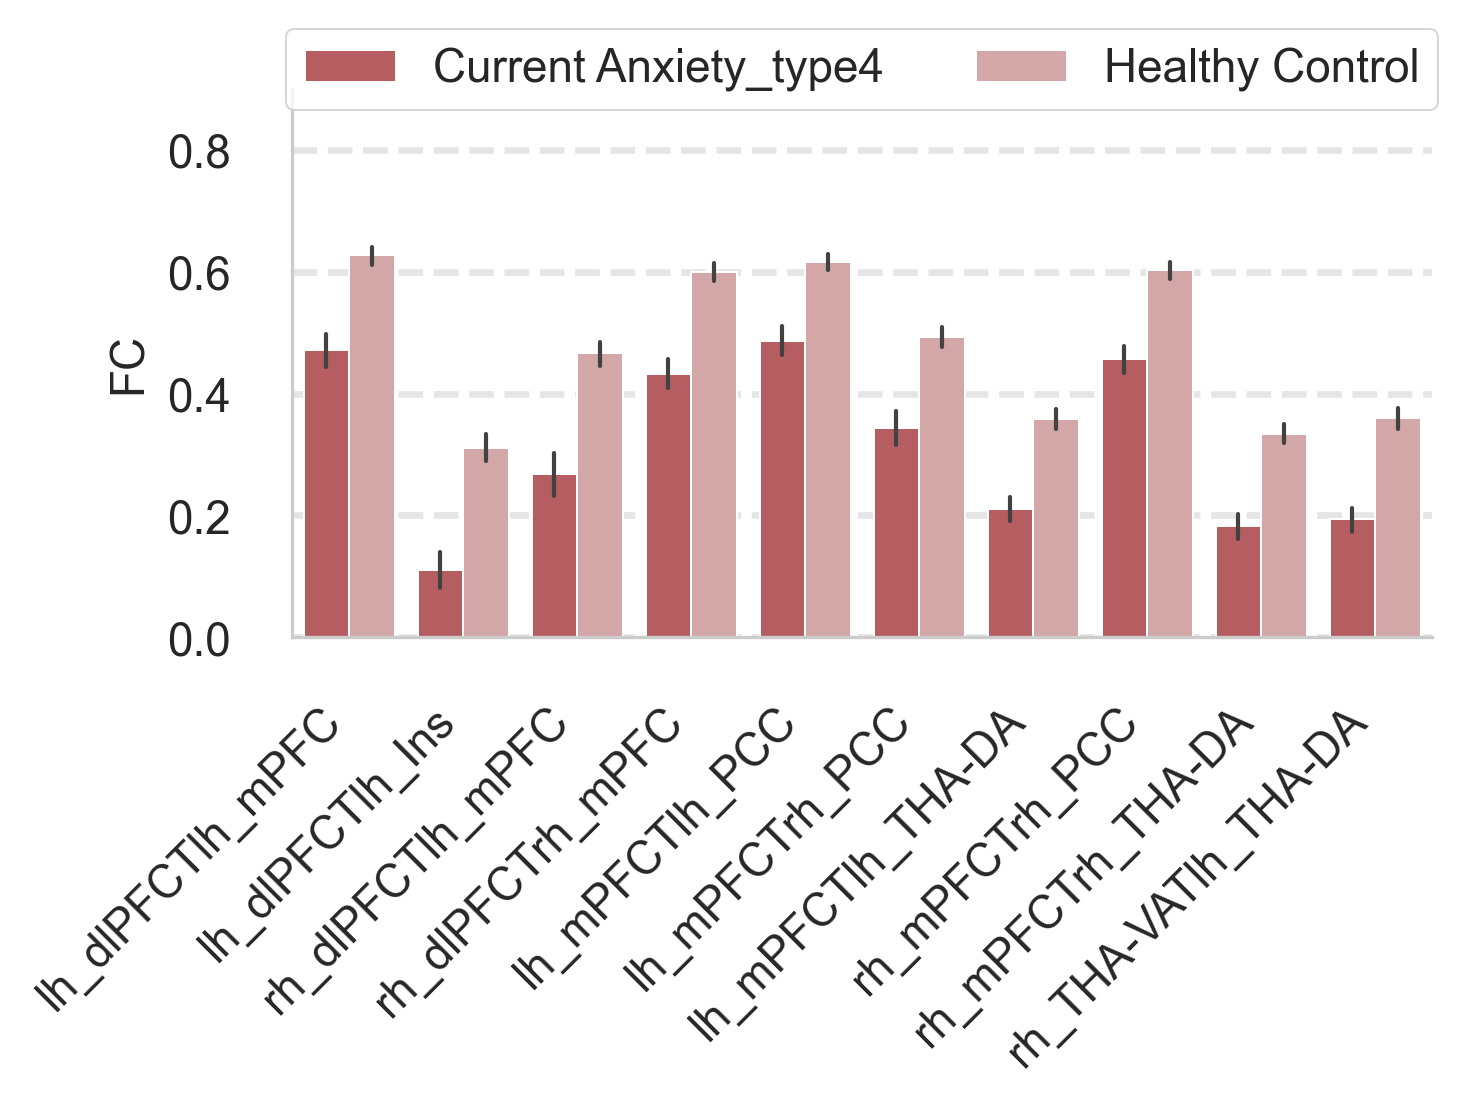

In [1200]:
df_bs_type4 = pd.DataFrame(X_type4[:, selected_features_data_set4])
df_bs_type4.columns = list(df_selected_features_type4['ROI'])
df_bs_type4['Anxiety'] = y_type4
# Relabel the 'Anxiety' column
df_bs_type4['Anxiety'] = df_bs_type4['Anxiety'].map({False: 'Healthy Control', True: 'Current Anxiety_type4'})

# Melt the dataframe to long format for seaborn compatibility
df_long = df_bs_type4.melt(id_vars=['Anxiety'], value_vars=df_bs_type4.columns[:-1],
                           var_name='Region', value_name='FC')

fig, ax = plt.subplots(figsize=(5, 4), dpi=300)
default_red = sns.color_palette("deep")[3]  # Red (#d62728)
lighter_red = sns.light_palette(default_red, n_colors=3)[1] 
# Create bar plot with thinner error bars
sns.barplot(
    x="Region", 
    y="FC", 
    hue="Anxiety", 
    data=df_long, 
    err_kws={"linewidth": 1},  # Thinner error bars
    palette=[default_red, lighter_red],  # Consistent blue/light blue color scheme
    ax=ax
)
# Fix x-tick positions and labels
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")  
# Customize plot
legend = plt.legend(title=None, loc="upper center", bbox_to_anchor=(0.5, 1.15), ncol=2)
plt.grid(axis="y", linestyle="--", alpha=0.5)  # Keep only y-grid for clarity
plt.xlabel("")
sns.despine()
plt.ylim(0, 0.9)

plt.tight_layout()

# Save and display the plot
#plt.savefig("bar_model4.png")
plt.show()


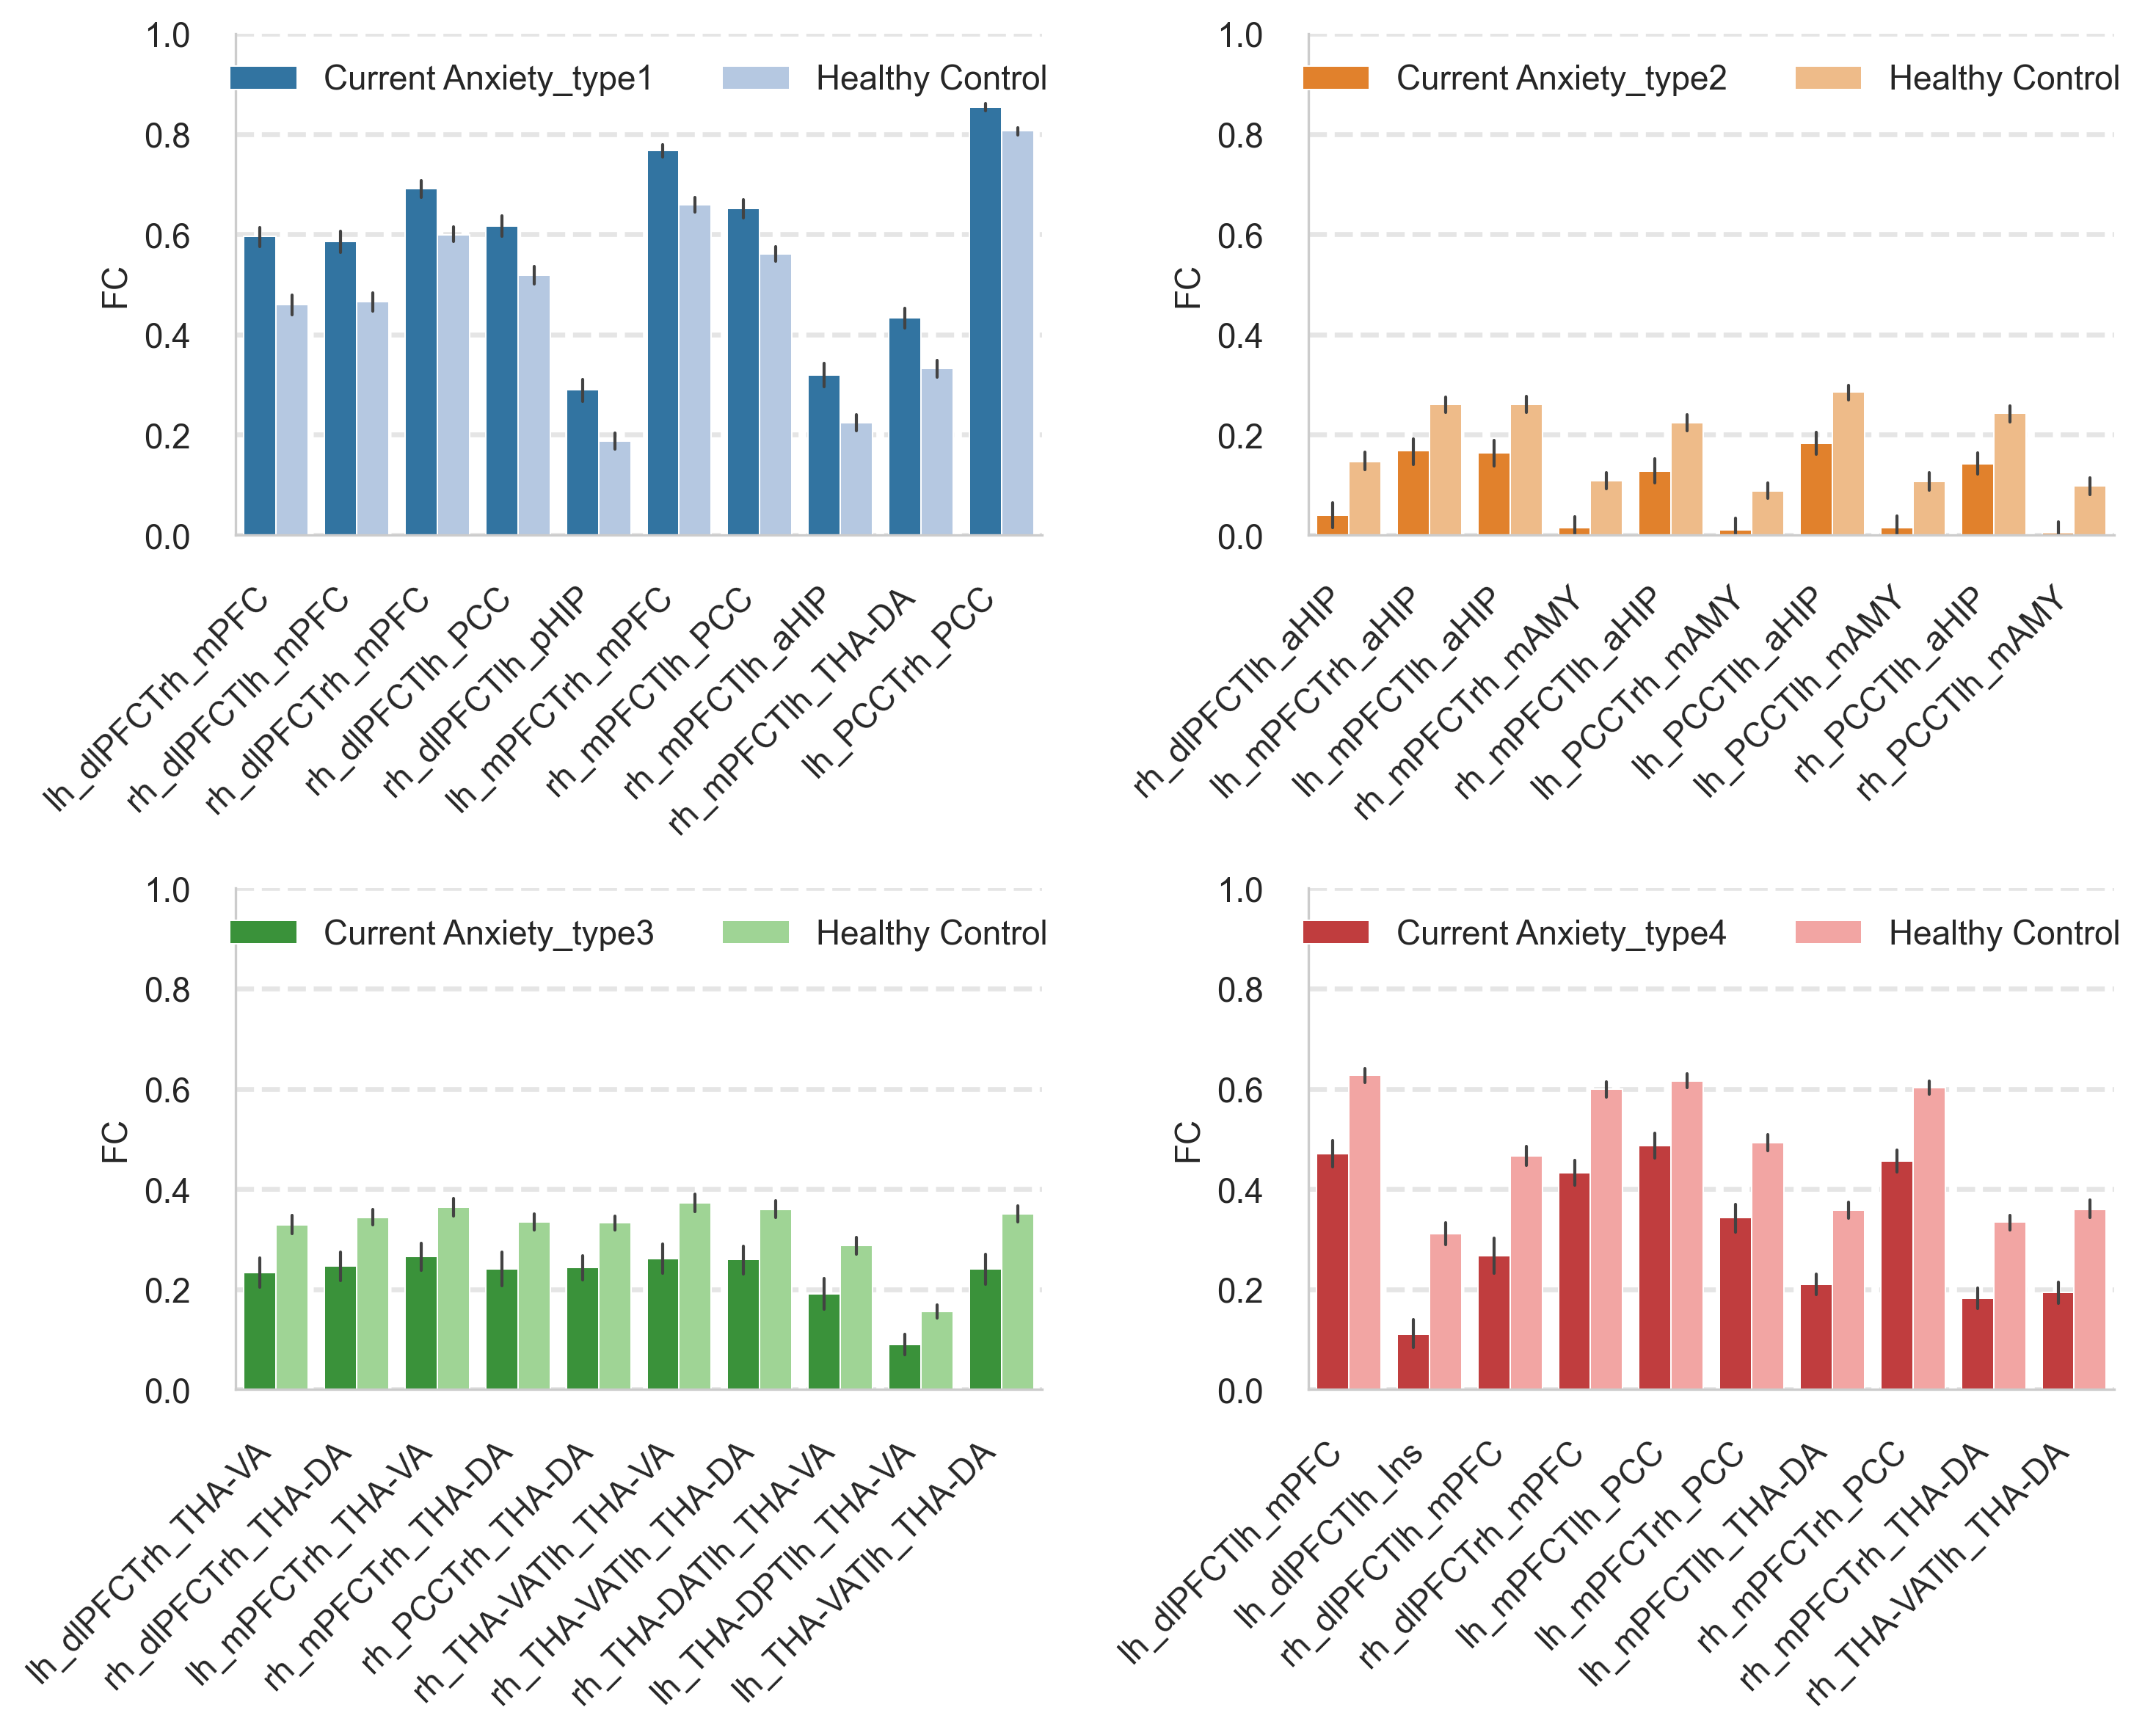

In [1214]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set style and font sizes
plt.style.use('seaborn-v0_8-poster')
fontsize = 11
plt.rcParams.update({
    "font.size": fontsize,
    "axes.labelsize": fontsize,
    "axes.titlesize": fontsize,
    "xtick.labelsize": fontsize,
    "ytick.labelsize": fontsize,
    "legend.fontsize": fontsize,
})

# Define figure and axes (2 rows, 2 columns)
fig, axes = plt.subplots(2, 2, figsize=(10, 8), dpi=300)

# Define dataset mappings
datasets = [
    (X_type1, selected_features_data_set1, df_selected_features_type1, y_type1, 'Current Anxiety_type1', axes[0, 0], ["#1f77b4", "#aec7e8"]),  # Blue shades
    (X_type2, selected_features_data_set2, df_selected_features_type2, y_type2, 'Current Anxiety_type2', axes[0, 1], ["#ff7f0e", "#ffbb78"]),  # Orange shades
    (X_type3, selected_features_data_set3, df_selected_features_type3, y_type3, 'Current Anxiety_type3', axes[1, 0], ["#2ca02c", "#98df8a"]),  # Green shades
    (X_type4, selected_features_data_set4, df_selected_features_type4, y_type4, 'Current Anxiety_type4', axes[1, 1], ["#d62728", "#ff9896"]),  # Red shades
]

# Iterate through datasets and generate subplots
for X_type, selected_features, df_selected_features, y_type, anxiety_label, ax, palette in datasets:
    df_bs = pd.DataFrame(X_type[:, selected_features])
    df_bs.columns = list(df_selected_features['ROI'])
    df_bs['Anxiety'] = y_type.map({False: 'Healthy Control', True: anxiety_label})

    # Melt for seaborn
    df_long = df_bs.melt(id_vars=['Anxiety'], var_name='Region', value_name='FC')

    # Bar plot
    sns.barplot(
        x="Region", y="FC", hue="Anxiety", data=df_long, err_kws={"linewidth": 1},
        palette=palette, ax=ax
    )

    # Customize plot
    ax.grid(axis="y", linestyle="--", alpha=0.5)
    ax.set_xlabel("")
    ax.set_ylim(0, 1)

    # Fix x-tick labels issue
    ax.set_xticks(range(len(ax.get_xticklabels())))  # Ensure fixed tick positions
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

    # Modify legend: single-row, centered below each plot, adjusted height
    ax.legend(title=None, loc="upper center", bbox_to_anchor=(0.5, 1), ncol=2, frameon=False)

sns.despine()

# Adjust layout
plt.tight_layout()
plt.savefig("bar_all_models.png")
plt.show()
